## import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
from pathlib import Path
import geopandas as gpd
import shapely
import pyttsx3
from shapely.geometry import Point,Polygon
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
%matplotlib inline  

## defining various function

In [2]:
# fuction which provide unique value in column 
def unique(data):
    for column in data.columns:
        print(f'{column}:',data[column].unique(),f':No. of unique values=',data[column].nunique(),end='\n\n')

In [3]:
# plot the correlation matrix
def correlation_matrix(data):
    plt.figure(figsize = (12,8))
    correlation_matrix = data.corr()                
    sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
    # return correlation_matrix   

In [4]:
def count_plot(data):
    # params:: data: dataset used for training
    
    Builder = data.groupby('POSTED_BY_Builder')['POSTED_BY_Builder'].agg('count')[1]   
    Dealer = data.groupby('POSTED_BY_Dealer')['POSTED_BY_Dealer'].agg('count')[1]
    Owner = data.shape[0] - Builder - Dealer
    
    plt.figure(figsize = (20,15))
    
    plt.subplot(3,2,1)
    sns.barplot([Dealer,Owner,Builder])
    plt.xticks([0,1,2],['Dealer','Owner','Builder'])
    plt.ylabel('count')
    plt.xlabel('POSTED_BY')
    
    plt.subplot(3,2,2)
    sns.countplot(x = data['UNDER_CONSTRUCTION'])
    
    plt.subplot(3,2,3)
    sns.countplot(x = data['BHK_OR_RK'])
    
    plt.subplot(3,2,4)
    sns.countplot(x = data['RERA'])
    
    plt.subplot(3,2,5)
    sns.countplot(x = data['READY_TO_MOVE'])
    
    plt.subplot(3,2,6)
    sns.countplot(x = data['RESALE'])
    
    plt.figure(figsize = (8,5))
    sns.countplot(x = data['BHK_NO.'])

In [5]:
def scatter_plot(data):
    # params:: data: dataset used for training
    
    plt.figure(figsize=(20,15))
    
    plt.subplot(3,2,1)
    sns.scatterplot(x=data['LONGITUDE'],y=data['TARGET(PRICE_IN_LACS)'])
    
    plt.subplot(3,2,3)
    sns.scatterplot(x=data['LATITUDE'],y=data['TARGET(PRICE_IN_LACS)'])

In [6]:
# kernel density plot
def kde_plot(data):
    # params:: data: dataset used for training
    
    plt.figure(figsize=(20,15))
    
    plt.subplot(3,2,1)
    sns.kdeplot(data['LONGITUDE'],fill=True,color='orange')
    
    plt.subplot(3,2,2)
    sns.kdeplot(data['LATITUDE'],fill=True,color='lime')
    
    plt.subplot(3,2,3)
    sns.kdeplot(data['SQUARE_FT'],fill=True,color='green')
    
    plt.subplot(3,2,4)
    sns.kdeplot(data['TARGET(PRICE_IN_LACS)'],fill=True,color='skyblue')
    
    plt.subplot(3,2,5)
    sns.kdeplot(data['BHK_NO.'],fill=True,color='cyan')

In [7]:
# plot the kde plot category-wise
def kde_plot_category(data):
    # params:: data: dataset used for training
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.kdeplot(data[data['POSTED_BY_Dealer'] == 1]['TARGET(PRICE_IN_LACS)'], color = 'black', label = 'Dealer', fill = True)
    sns.kdeplot(data[data['POSTED_BY_Owner'] == 1]['TARGET(PRICE_IN_LACS)'], color = 'orange', label = 'Owner')
    sns.kdeplot(data[data['POSTED_BY_Builder'] == 1]['TARGET(PRICE_IN_LACS)'], color = 'blue', label = 'Builder')
    plt.title('Posted by')
    plt.legend()
    
    plt.subplot(1,2,2)
    sns.kdeplot(data[data['RESALE'] == 1]['TARGET(PRICE_IN_LACS)'], color = 'k', label = '1')
    sns.kdeplot(data[data['RESALE'] == 0]['TARGET(PRICE_IN_LACS)'], color = 'blue', label = '0', fill = True)
    plt.title('Resale')
    plt.legend()

In [8]:
def hist_plot(data):
    # params:: data: dataset used for training
    
    sns.histplot(data['BHK_NO.'],
                 binwidth = 1,
                 binrange = (1,20),
                 stat = 'probability',
                 cumulative = True,
                 fill = False)  

In [9]:
def box_plot(data,column):
    # params:: 
    # data: dataset used for training
    # column : column name in dataset
    
    plt.figure(figsize = (20,15))
    
    plt.subplot(3,2,1)
    sns.boxplot(y = data[column], hue = data['RESALE'], x = data['BHK_OR_RK'])
    
    plt.subplot(3,2,2)
    sns.boxplot(y = data[column], x = data[data['POSTED_BY_Owner'] == 1]['POSTED_BY_Owner'])
    
    plt.subplot(3,2,3)
    sns.boxplot(y = data[column], x = data[data['POSTED_BY_Dealer']==1]['POSTED_BY_Dealer'])
    
    plt.subplot(3,2,4)
    sns.boxplot(y = data[column], x = data[data['POSTED_BY_Builder'] == 1]['POSTED_BY_Builder'])
    
    plt.subplot(3,2,5)
    sns.boxplot(y = data[column], x = data['READY_TO_MOVE'])
    
    plt.subplot(3,2,6)
    sns.boxplot(y = data[column], x = data['RERA'])
    
    plt.figure(figsize = (20,15))
    sns.boxplot(y = data[column], x = data['BHK_NO.'])

In [10]:
# defining accuracy for checking model performance on unseen dataset
def accuracy(model, X_test, y_test):
    # params::
    # model : pre-trained model
    # X_test : feature dataset used for testing
    # y_test : label dataset used for testing

    y_pred = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    
    print(f'mean_absolute_error : {MAE}')
    print(f'mean_squared_error : {MSE}')
    print(f'r2_score : {r2}')

In [11]:
# using gridsearchcv find the best model (hyper parameter tuning)
def find_best_model_using_gridsearchcv(X, y):
    # params::
    # X : feature dataset
    # y : label dataset

    #create directory for storing hyperparameter tuned model results
    model_dir = Path.cwd() / 'hyperparameter_tuned_model'
    model_dir.mkdir(parents = True, exist_ok = True)

    # model along with hyperparameter used for tuning
    algos={
        'linear_regression':{
            'model':LinearRegression(),
            'params':{
                'fit_intercept':[True,False]
            }
        },
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion':['poisson', 'squared_error','friedman_mse'],
                'splitter':['best','random']
            }
        },
        'random_forest':{
            'model':RandomForestRegressor(),
            'params':{
                'criterion':['poisson', 'squared_error','friedman_mse'],
                'n_estimators':[5,10,15]
            }
        },
        'gradient_boost':{
            'model':GradientBoostingRegressor(),
            'params':{
                'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
                'learning_rate':[0.05,0.1,0.15],
                'n_estimators':[5,10,15],
                'criterion':['friedman_mse', 'squared_error']
            }
        },
        'ada_boost':{
            'model':AdaBoostRegressor(),
            'params':{
                'loss':['linear', 'square', 'exponential'],
                'learning_rate':[0.5,1,1.5],
                'n_estimators':[5,10,15],
            }
        },
        'xg_boost':{
            'model':XGBRegressor(),
            'params':{
                'n_estimators':[10,15,20]
            }
        }
    }

    # for storing the model name along with best score and parameter 
    scores = []

    # split the dataset for cross validation 
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2)

    # for loop for traversing through dictionary
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False, n_jobs = -1)
        gs.fit(X, y)
        scores.append({
        'model':algo_name,
        'best_estimator':gs.best_estimator_,
        'best_score':gs.best_score_,
        'best_params':gs.best_params_
        })
        result = pd.DataFrame(gs.cv_results_)
        file_name = model_dir / f'{algo_name}.csv'
        result.to_csv(file_name)
    return pd.DataFrame(scores, columns = ['model', 'best_estimator', 'best_score', 'best_params'])

In [12]:
# open the hyperparameter tuned result
def open_tuned_model_result(model_name):
    # params:: model_name : (str) 
    
    model_dir = Path.cwd() / 'hyperparameter_tuned_model'
    file_name = model_dir / f'{model_name}.csv'
    result = pd.read_csv(file_name)
    result.sort_values('rank_test_score')
    return result

In [13]:
# return the trained model
def model_fitting(model, X_train, y_train):
    # params::
    # model : estimator used to fit the data
    # X_train : training dataset (features)
    # y_train : training dataset (labels)
    
    model.fit(X_train, y_train)
    return model

In [14]:
# return pandas Dataframe with stacked_model in it
def stack_model(result, X_train, y_train, cv = 5):
    # params::
    # model_result : (pandas DataFrame) result returned after hypertuning using gridsearchcv
    # cv     : (int) cross validation split

    model_result = result.copy()
    model = list()
    final_model = ''
    rows = model_result.shape[0]
    
    for i in range(rows):
        model_name = model_result['model'][i]
        estimator = model_result['best_estimator'][i]
        if model_name != 'linear_regression':
            model.append((model_name, estimator))
        else:
            final_model = estimator
            
    if final_model == '' :
            final_model = LinearRegression()

    # stacked model estimator
    stacked_model_estimator = StackingRegressor(estimators = model, final_estimator = final_model, cv = cv, n_jobs = -1)

    # model fitted on training data
    stacked_model = model_fitting(stacked_model_estimator, X_train, y_train)

    # adding model to DataFrame
    model_result.loc[rows] = pd.Series()
    model_result.loc[rows, ['model', 'best_estimator']] = ['stacked_model', stacked_model]
    return model_result

In [15]:
# give the cross-validation-score
def evaluate_models_cross_val_score(model, X, y):
    # params::
    # model : estimator used to fit the data
    # X     : training dataset (features)
    # y     : training dataset (labels)
    
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    scores = cross_val_score(model, X, y, cv = cv, n_jobs = -1)
    return scores

In [16]:
# give the r2_score 
def model_evaluation(model, X_test, y_test):
    # params::
    # model : trained model obtained from model_fitting function
    # X_test : testing dataset (features)
    # y_test : testing dataset (labels)
    
    r2_score = model.score(X_test, y_test)
    return r2_score

In [17]:
# scatter-plot between predicted and actual label as well as their individual distribution
def joint_plot(model, X_test, y_test):
    # params::
    # model : trained model obtained from model_fitting function
    # X_test : testing dataset (features)
    # y_test : testing dataset (labels)
    
    y_pred = model.predict(X_test)
    sns.jointplot(x = y_test, y = y_pred, kind = 'reg')

In [18]:
# save the trained model
def save_model(model, model_name):
    # params::
    # model      : trained model obtained from model_fitting function
    # model_name : (str) 
    
    #create directory for storing model
    model_dir = Path.cwd() / 'saved_model'
    model_dir.mkdir(parents = True, exist_ok = True)

    file_name = model_dir / f'{model_name}.h5'
    pickle.dump(model, open(file_name,'wb'))

In [19]:
# load the trained model from hard disk to memory
def open_save_model(model_name):
    # params:: model_name : (str) 
    
    model_dir = Path.cwd() / 'saved_model'
    file_name = model_dir / f'{model_name}.h5'
    model = pickle.load(open(file_name,'rb'))
    return model

In [20]:
def predict_price(under_construction, rera, bhk_no, bhk_or_rk, square_ft, resale, longitude, latitude, posted_by):
    
    under_construction = under_construction.lower()
    valid_inputs_for_under_construction = ['yes', 'no']
    if under_construction not in valid_inputs_for_under_construction:
        print("invalid input for under_construction: please insert either 'yes' or 'no' ")
        return 
    else:
        if under_construction == 'yes':
            under_construction = 1
        else: 
            under_construction = 0

    rera = rera.lower()
    valid_inputs_for_rera = ['yes', 'no']
    if rera not in valid_inputs_for_rera:
        print("invalid input for rera: please insert either 'yes' or 'no' ")
        return 
    else:
        if rera == 'yes':
            rera = 1
        else: 
            rera = 0

    if bhk_no >= 7 or type(bhk_no) != int:
        print("please insert integer value for BHK_NO. between 1 to 6 ")
        return

    bhk_or_rk = bhk_or_rk.lower()
    valid_inputs_for_bhk_or_rk = ['bhk', 'rk']
    if bhk_or_rk not in valid_inputs_for_bhk_or_rk:
        print("invalid input for bhk_or_rk: please insert either 'bhk' or 'rk' ")
        return
    else:
        if bhk_or_rk == 'bhk':
            bhk_or_rk = 1
        else: 
            bhk_or_rk = 0

    resale = resale.lower()
    valid_inputs_for_resale = ['yes', 'no']
    if resale not in valid_inputs_for_resale:
        print("invalid input for resale: please insert either 'yes' or 'no' ")
        return
    else:
        if resale == 'yes':
            resale = 1
        else: 
            resale = 0

    posted_by = posted_by.lower()
    valid_inputs_for_posted_by = ['builder', 'owner', 'dealer']
    if posted_by not in valid_inputs_for_posted_by:
        print("invalid input for posted by: please insert 'builder' or 'owner' or 'dealer' ")
        return

    if not ((68 < longitude < 97) and (8 < latitude < 37)):
        print("please insert co-ordinate which is in India")
        return

    pyttsx3.speak('successfully entered the data')
    if posted_by == 'builder':
        array = [under_construction, rera, bhk_no, bhk_or_rk, square_ft, resale, latitude, longitude, 1, 0]
    elif posted_by == 'dealer':
        array = [under_construction, rera, bhk_no, bhk_or_rk, square_ft, resale, latitude, longitude, 0, 1]
    else:
        array = [under_construction, rera, bhk_no, bhk_or_rk, square_ft, resale, latitude, longitude, 0, 0]

    # load the MinMaxScaler
    file_name = Path.cwd() / 'minmaxscaler' / 'MinMaxScaler.pkl'
    minmax = pickle.load(open(file_name, 'rb'))

    # convert 1D array to 2D array (model requirement)
    array = np.expand_dims(array, axis = 0)

    # transform 2D array using MinMaxScaler
    transformed_array = minmax.transform(array)

    # load the model
    model_name = 'stacked_model'
    model_path = Path.cwd() / 'saved_model' / f"{model_name}.h5"
    model = pickle.load(open(model_path,'rb'))

    # predict the price
    predicted_price = model.predict(transformed_array)[0]
    pyttsx3.speak(f"The predicte price is {round(predicted_price,3)} lacs")
    return predicted_price



## loading the dataset 

In [21]:
# dataset 
file_name = Path.cwd() / 'data' / 'train.csv'
data = pd.read_csv(file_name)
data.sample(5)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
8227,Dealer,0,0,3,BHK,2588.867868,1,1,"Banashankari,Bangalore",12.969910,77.597960,260.0
21023,Owner,0,0,2,BHK,1400.037334,1,1,"Pimpri,Pune",18.618620,73.803730,75.0
27369,Owner,0,0,2,BHK,1099.387338,1,1,"Khodiyar Colony,Jamnagar",22.474577,70.049742,32.3
3188,Owner,0,0,2,BHK,1085.069444,1,1,"Sundarpada,Bhubaneswar",20.230195,85.816005,25.0
7063,Dealer,0,0,3,BHK,4000.000000,1,1,"Shyam Nagar,Jaipur",26.809242,75.741434,100.0


In [22]:
# india shapefile
file_path = Path.cwd() / "data" / "India" / "IND_adm0.shp" 
India_shapefile = gpd.read_file(file_path)
India_shapefile.head()

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,105,IND,India,107,IND,India,INDIA,India,Bharat,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."


Text(0.5, 1.0, 'India')

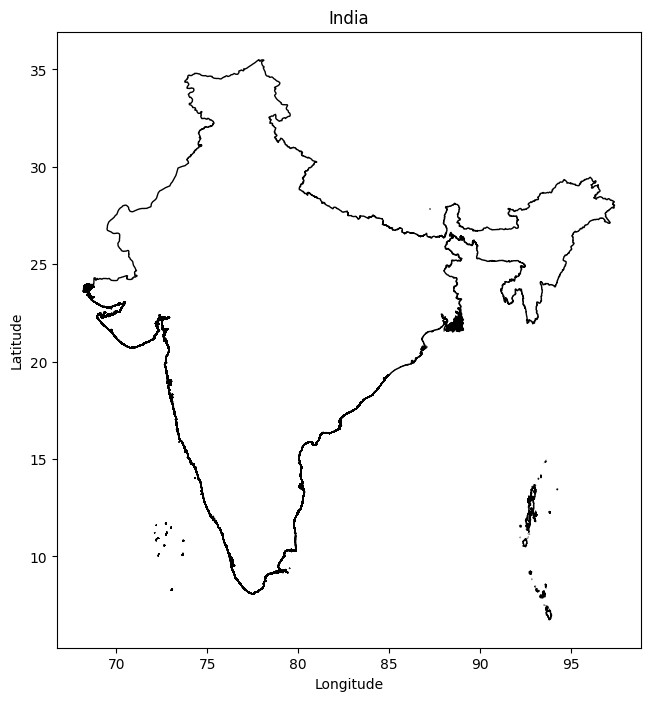

In [24]:
India_shapefile.plot(fc = 'white', ec = 'k', figsize = (8,8))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('India')

## EDA and Feature engineering

In [25]:
# provide information (data type, null value count) about columns in dataset 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


In [26]:
# provide the information regarding statistics
data.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


In [27]:
# observation:
# mean and standard deviation is very less as compared to maximum value in 'TARGET(PRICE_IN_LACS)' feature. same can be seen in 'SQUARE_FT' feature
# minimum valus for longitude and lattitude is negative and name of it's column is reversed

In [28]:
# correct the column name for latitude and longitude
data.rename(columns = {'LATITUDE': 'LONGITUDE', 'LONGITUDE':'LATITUDE'}, inplace = True)

Text(0.5, 1.0, 'Map')

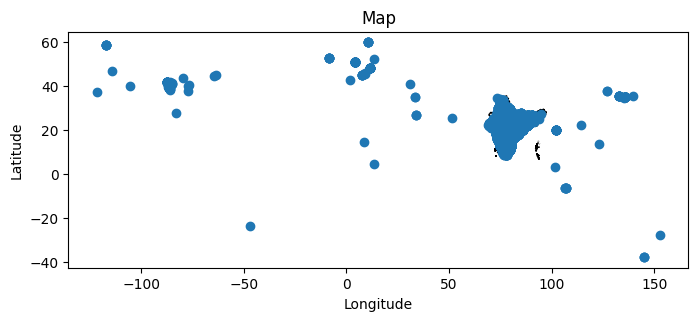

In [29]:
# location of houses along with respect to india
ax = India_shapefile.plot(fc = 'white', ec = 'k', figsize = (8,8))
ax.scatter([lon for lon in data['LONGITUDE']], [lat for lat in data['LATITUDE']])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map')

In [30]:
# house price prediction is for India so drop the irrelevent location
data1 = data[~((data['LONGITUDE'] < 68) | (data['LONGITUDE'] > 97) | (data['LATITUDE'] > 37) | (data['LATITUDE'] < 8))].reset_index()
data1.drop('index', inplace = True, axis = 1)

Text(0.5, 1.0, 'India')

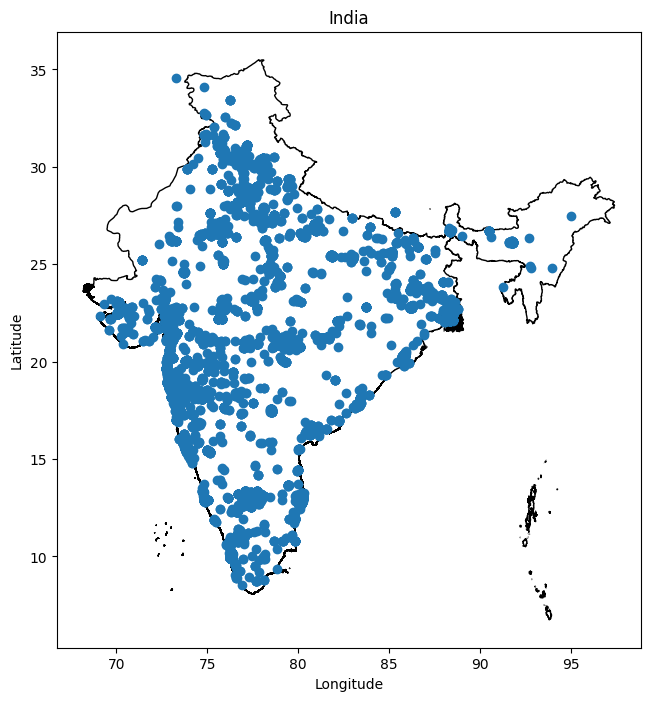

In [31]:
# location of houses along with respect to india after removing the irrelevant location
ax = India_shapefile.plot(fc = 'white', ec = 'k', figsize = (8,8))
ax.scatter([lon for lon in data1['LONGITUDE']], [lat for lat in data1['LATITUDE']])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('India')

In [32]:
unique(data1)

POSTED_BY: ['Owner' 'Dealer' 'Builder'] :No. of unique values= 3

UNDER_CONSTRUCTION: [0 1] :No. of unique values= 2

RERA: [0 1] :No. of unique values= 2

BHK_NO.: [ 2  3  1  4  5  6 12  8 20 10  7  9 13 17 15 11] :No. of unique values= 16

BHK_OR_RK: ['BHK' 'RK'] :No. of unique values= 2

SQUARE_FT: [1300.236407  1275.         933.1597222 ... 1022.641509   927.0790093
  896.7741935] :No. of unique values= 19417

READY_TO_MOVE: [1 0] :No. of unique values= 2

RESALE: [1 0] :No. of unique values= 2

ADDRESS: ['Ksfc Layout,Bangalore' 'Vishweshwara Nagar,Mysore' 'Jigani,Bangalore'
 ... 'Varunji Cross Road,Karad' 'west mambalam,Chennai'
 'Gandhi Nagar,Gulbarga'] :No. of unique values= 6810

LATITUDE: [12.96991  12.274538 12.778033 ... 18.565321 18.9737   17.357159] :No. of unique values= 4028

LONGITUDE: [77.59796  76.644605 77.632191 ... 73.812791 73.3321   76.841908] :No. of unique values= 4019

TARGET(PRICE_IN_LACS): [  55.    51.    43.  ... 1170.  8660.    18.3] :No. of unique values

In [33]:
# dropping unnecessary columns from daatset
data1.drop('ADDRESS', axis = 1, inplace = True)  

# replacing categorical values into integer
data1.replace({'BHK' : 1 ,'RK' : 0}, inplace = True)

# one hot encoding 
data1 = pd.get_dummies(data1, columns = ['POSTED_BY'], dtype = int)

## visuallizing the data using various graphs and find the meaningful observations from them

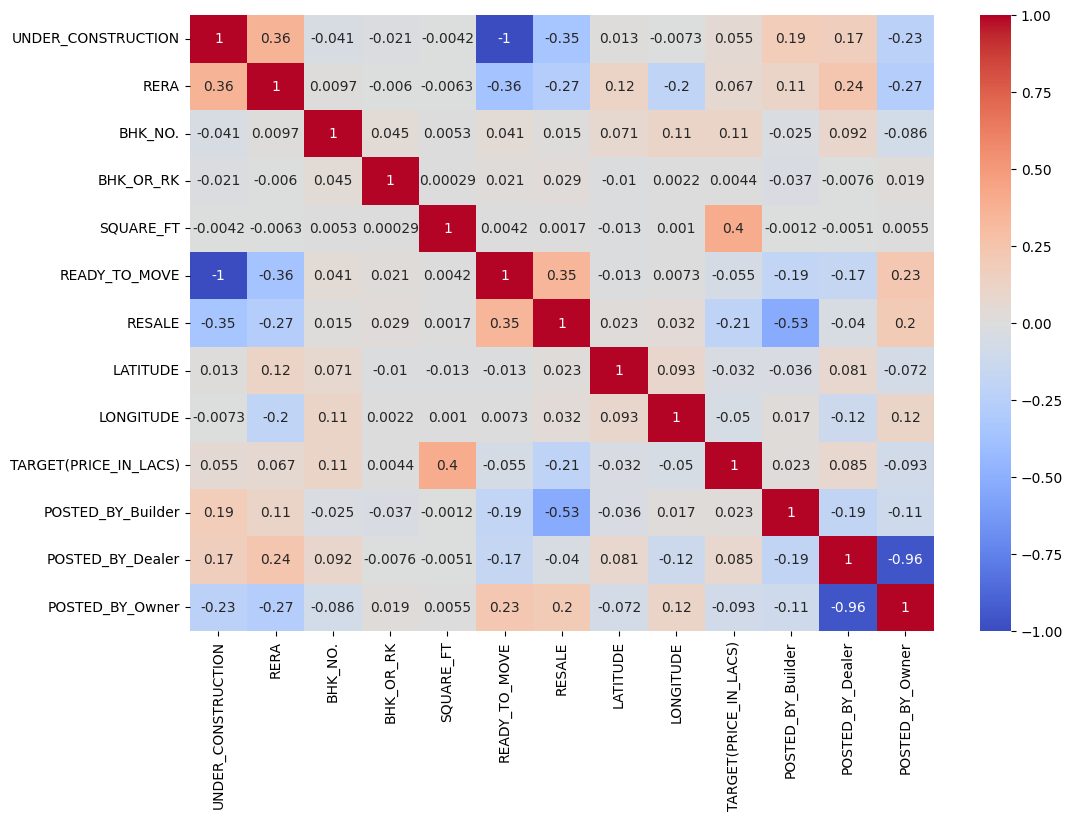

In [34]:
#corelation matrix before cleaning data (except for removal of address column)
correlation_matrix(data1)   

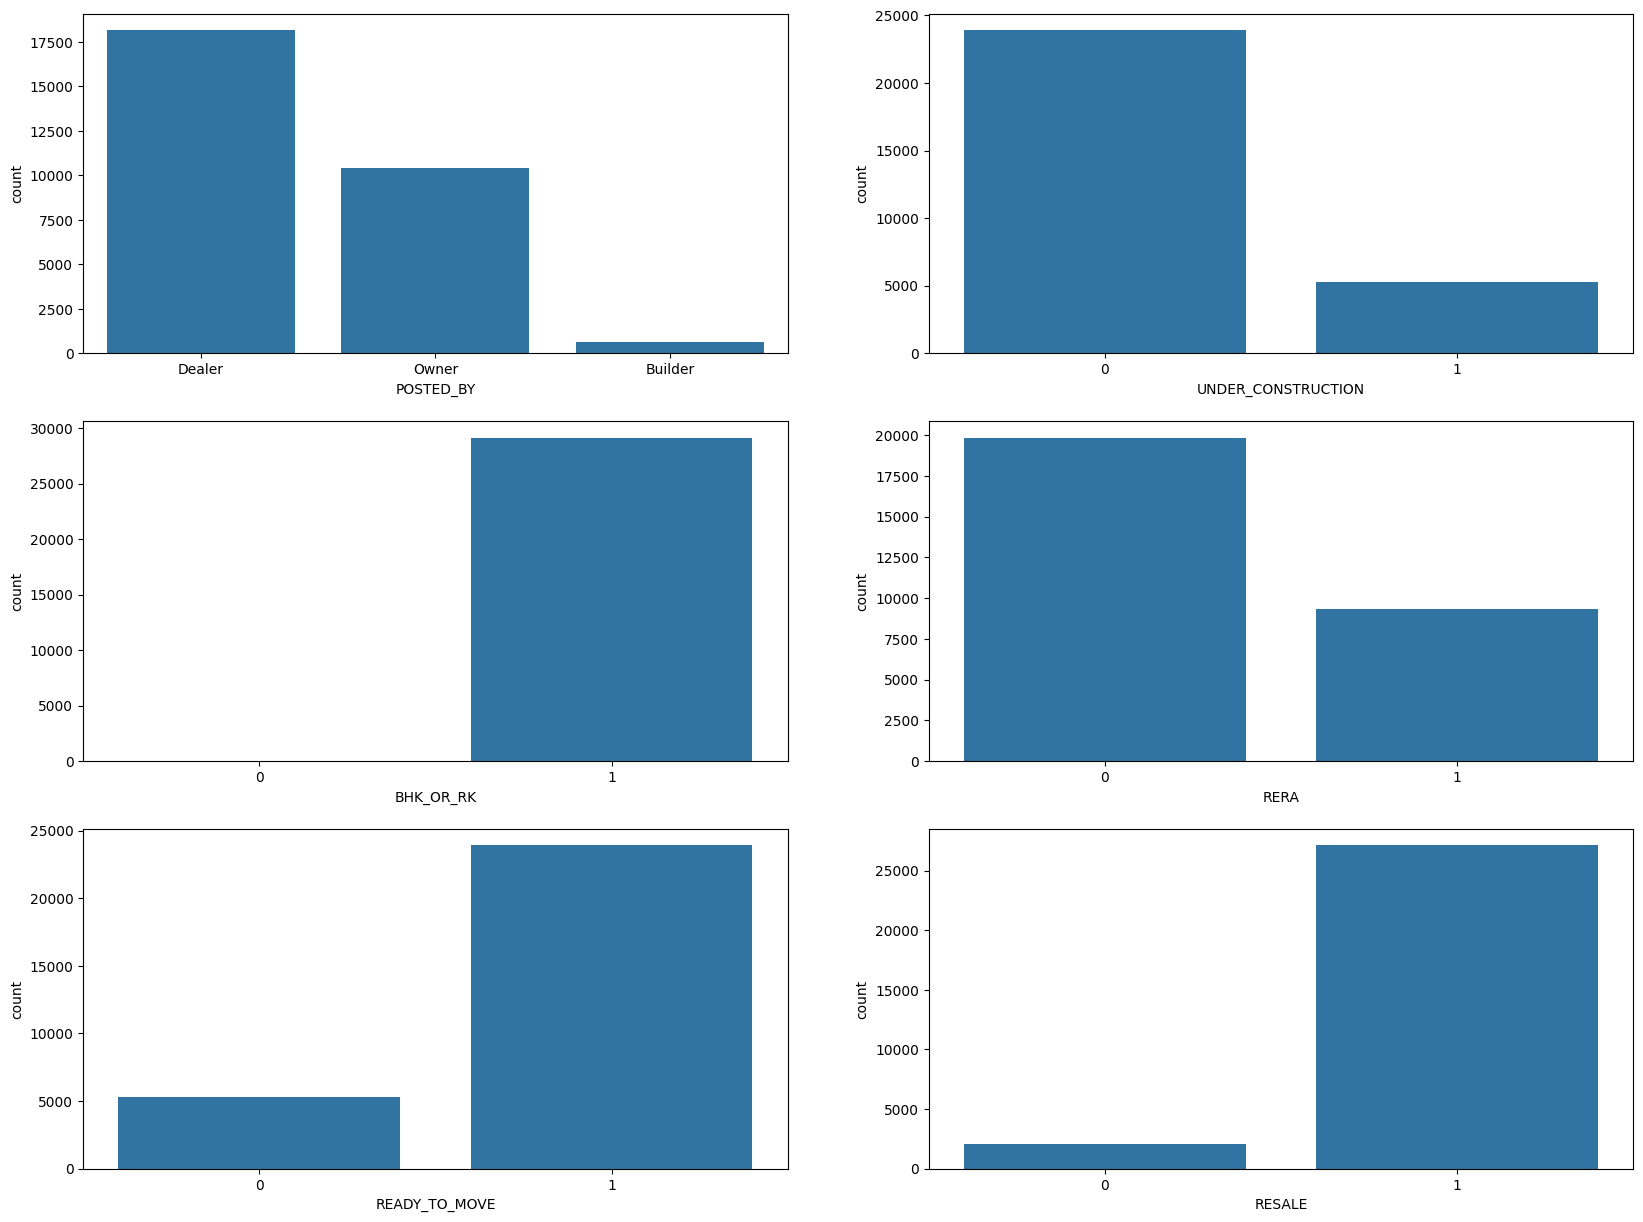

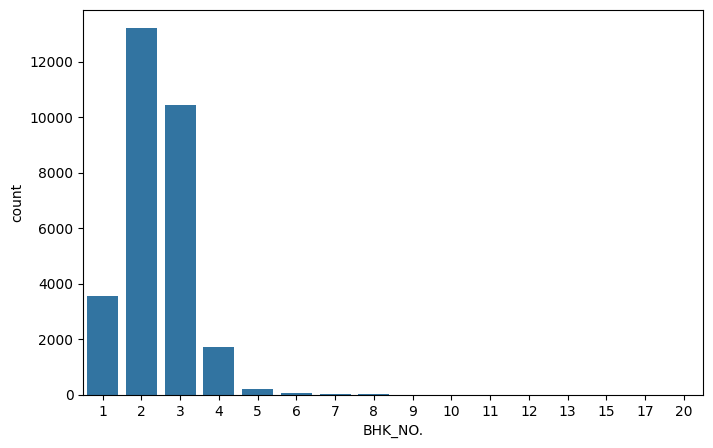

In [35]:
count_plot(data1)

In [36]:
# observations : (count plot)
# feature : 'BHK_OR_RK' : very less data regarding RK
# feature : 'BHK_NO.'  : very less data for BHK_NO. > 7
# feature : 'POSTED_BY' : less number of house posted by builder

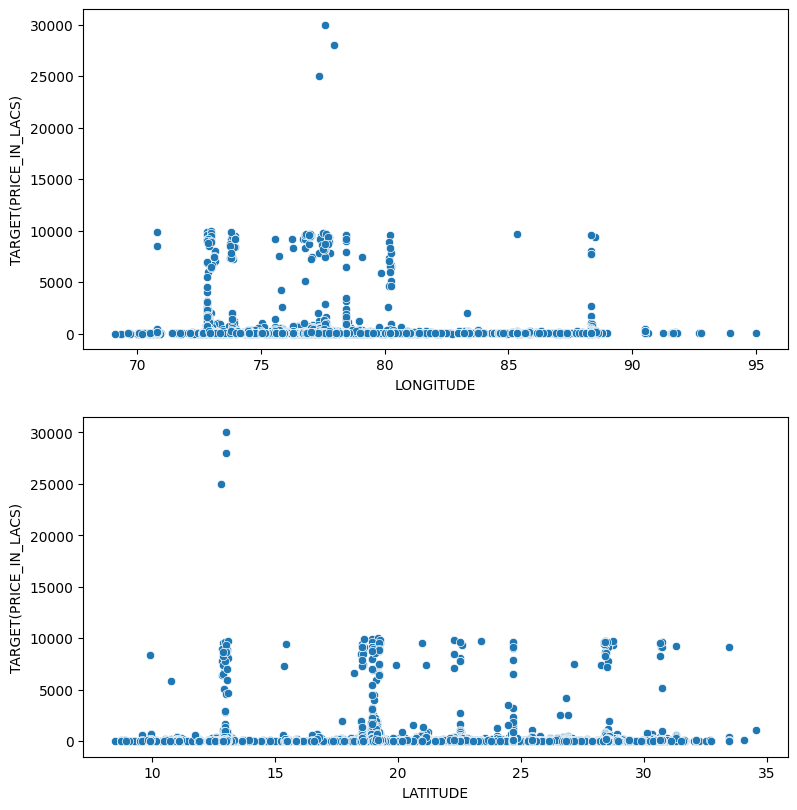

In [37]:
scatter_plot(data1)

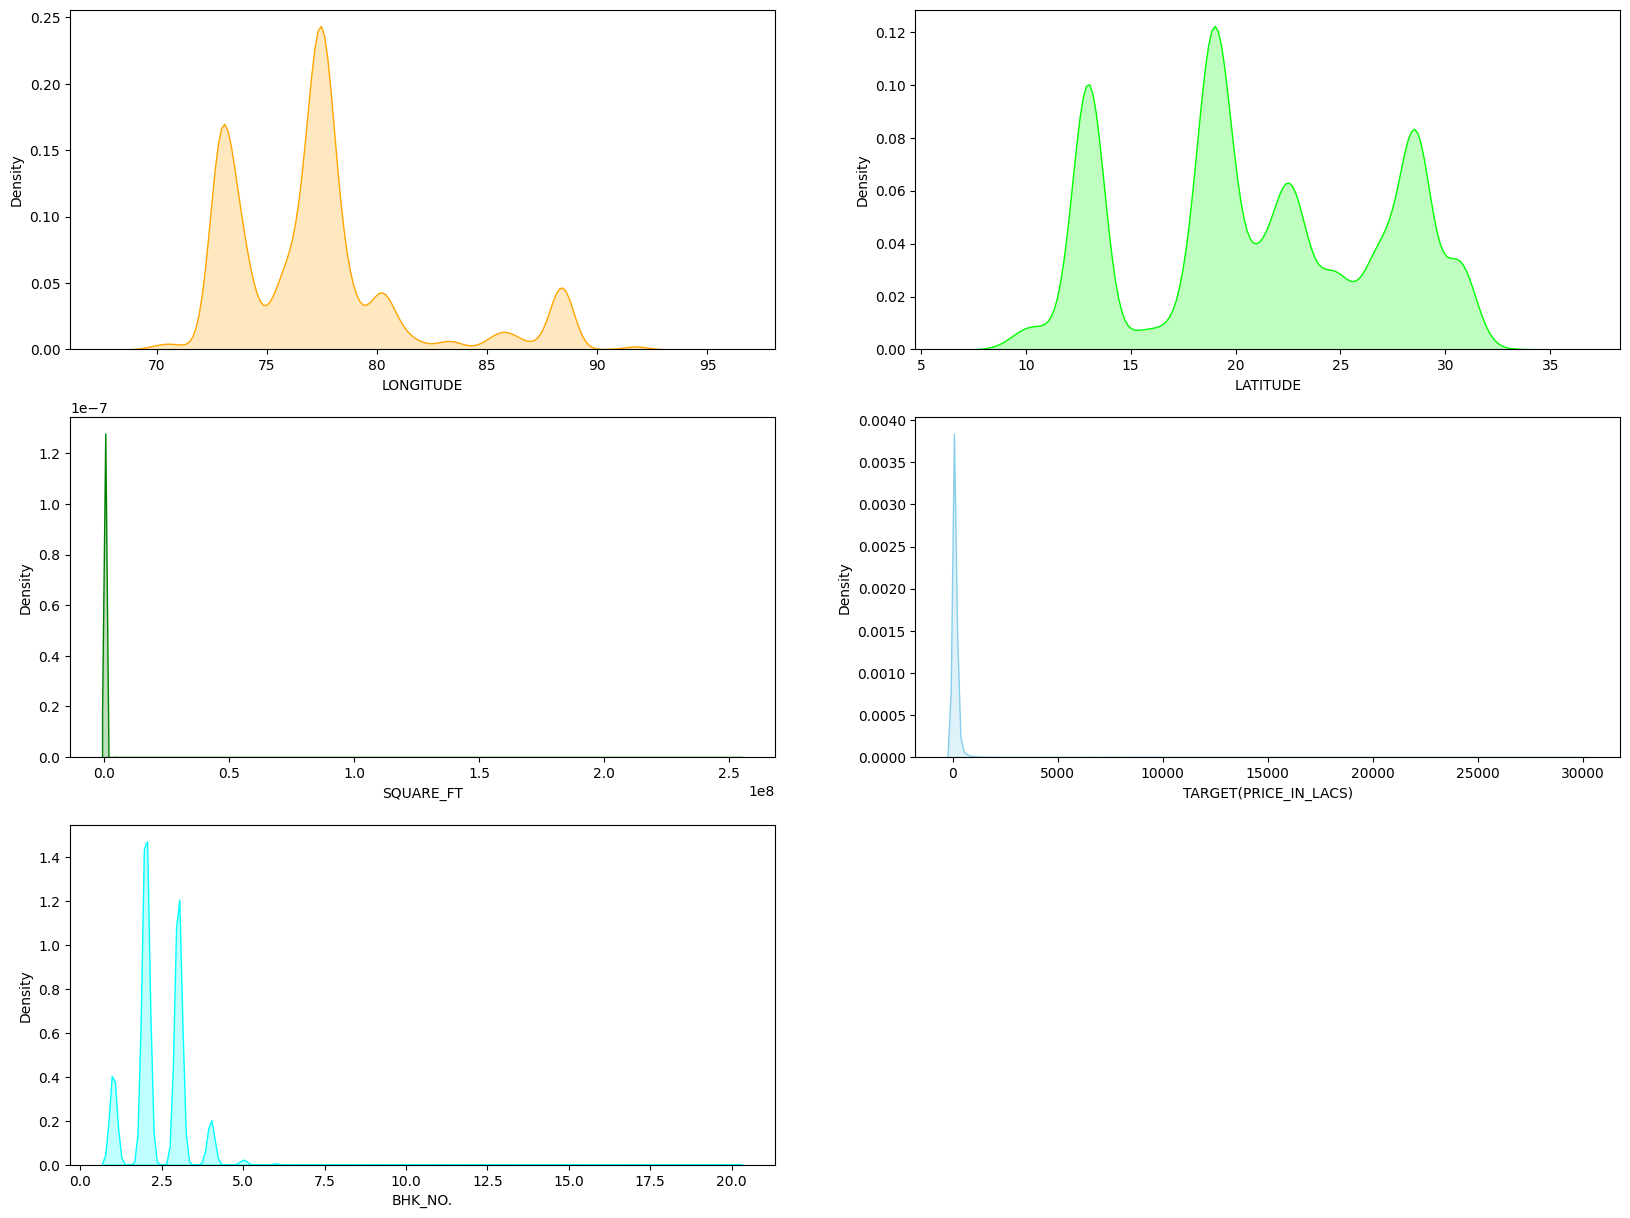

In [38]:
kde_plot(data1)

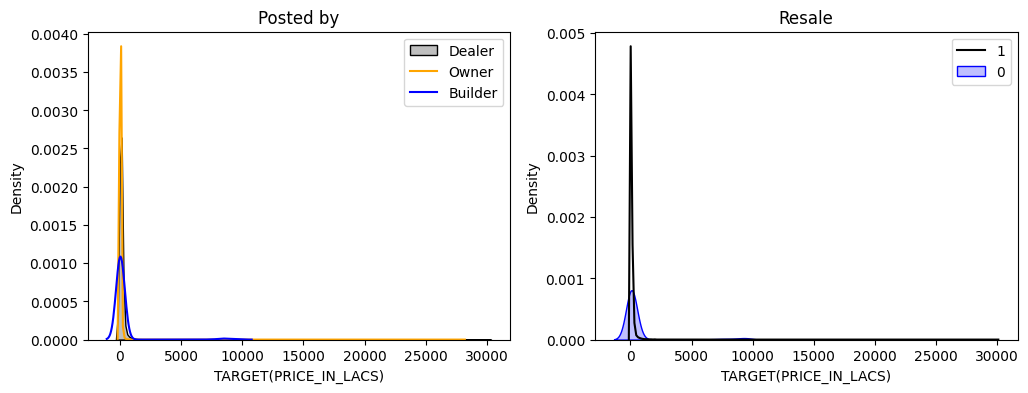

In [39]:
kde_plot_category(data1)

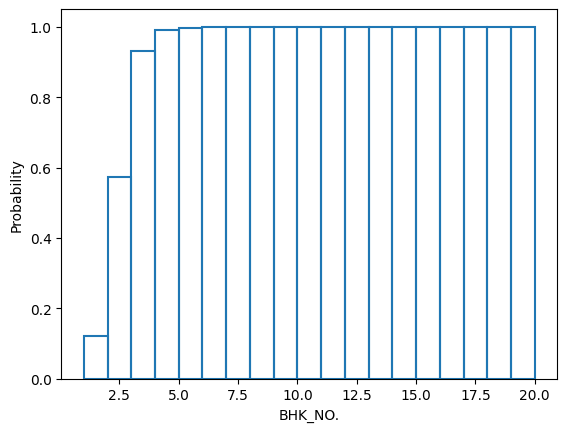

In [40]:
hist_plot(data1)

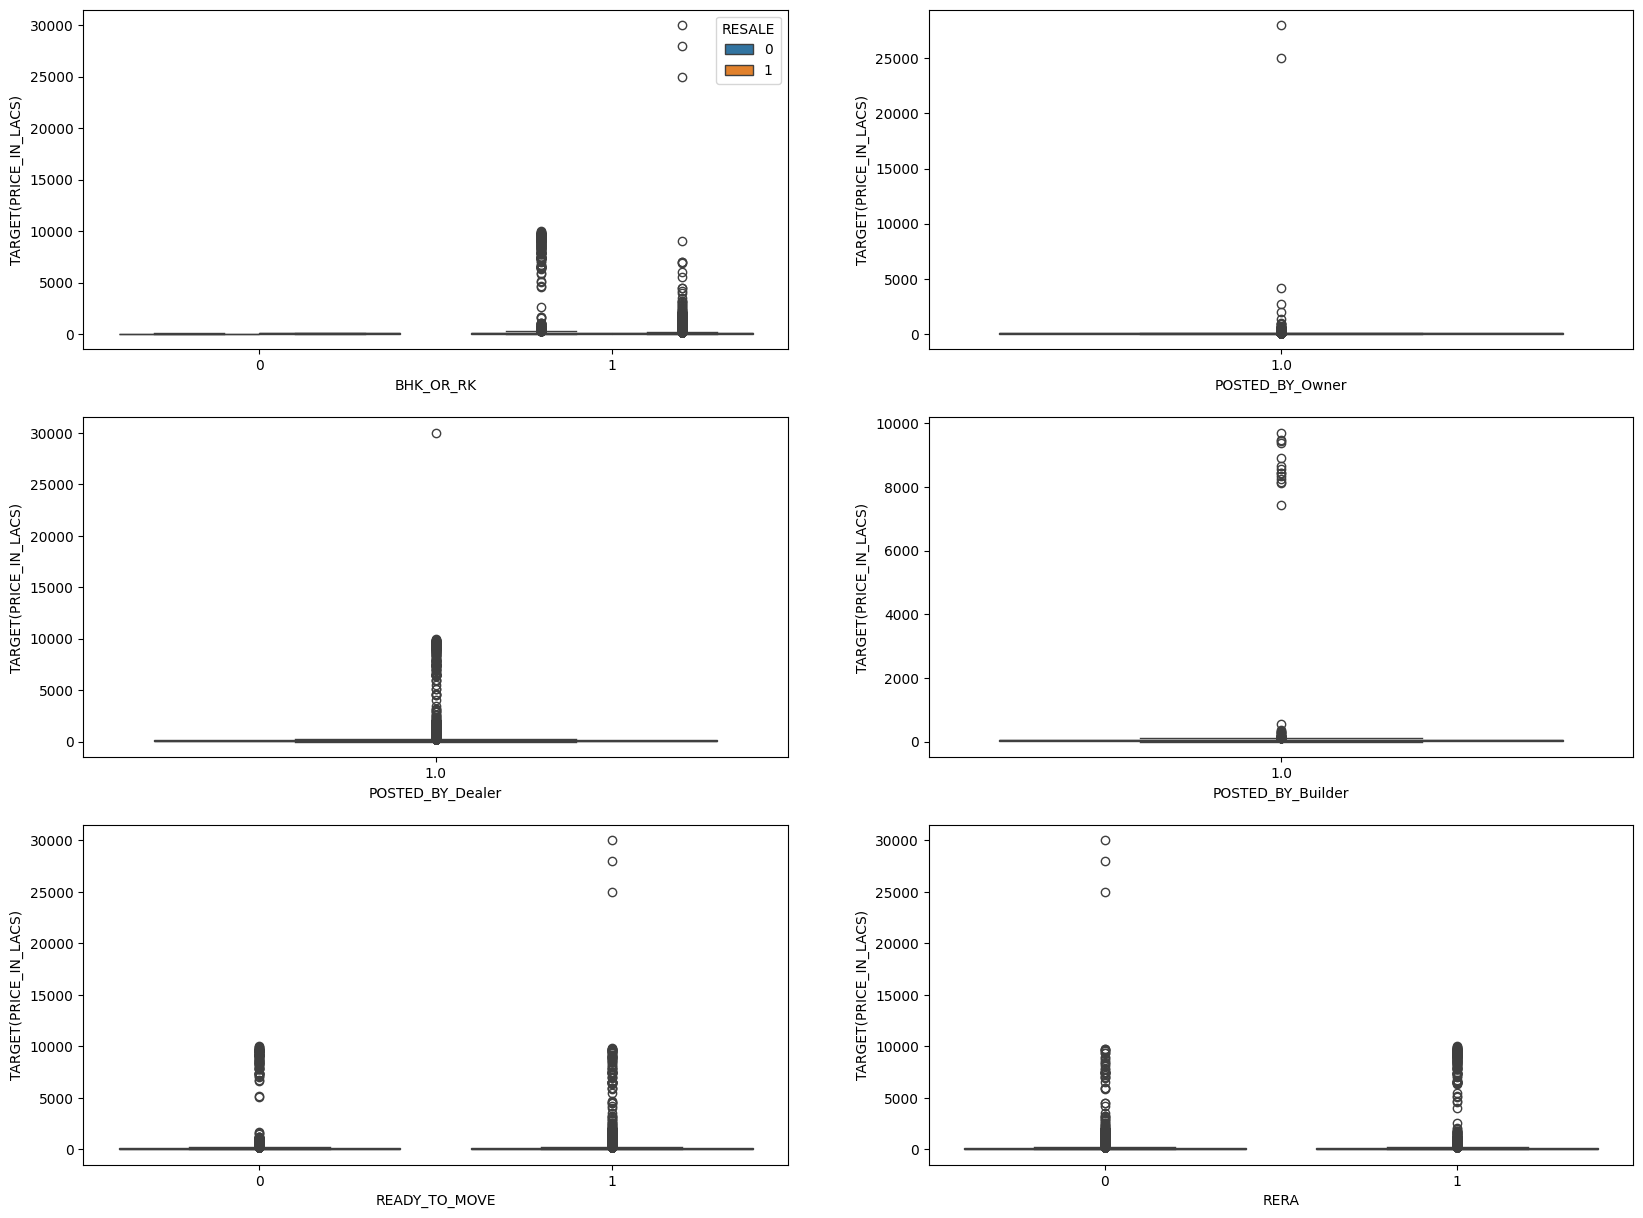

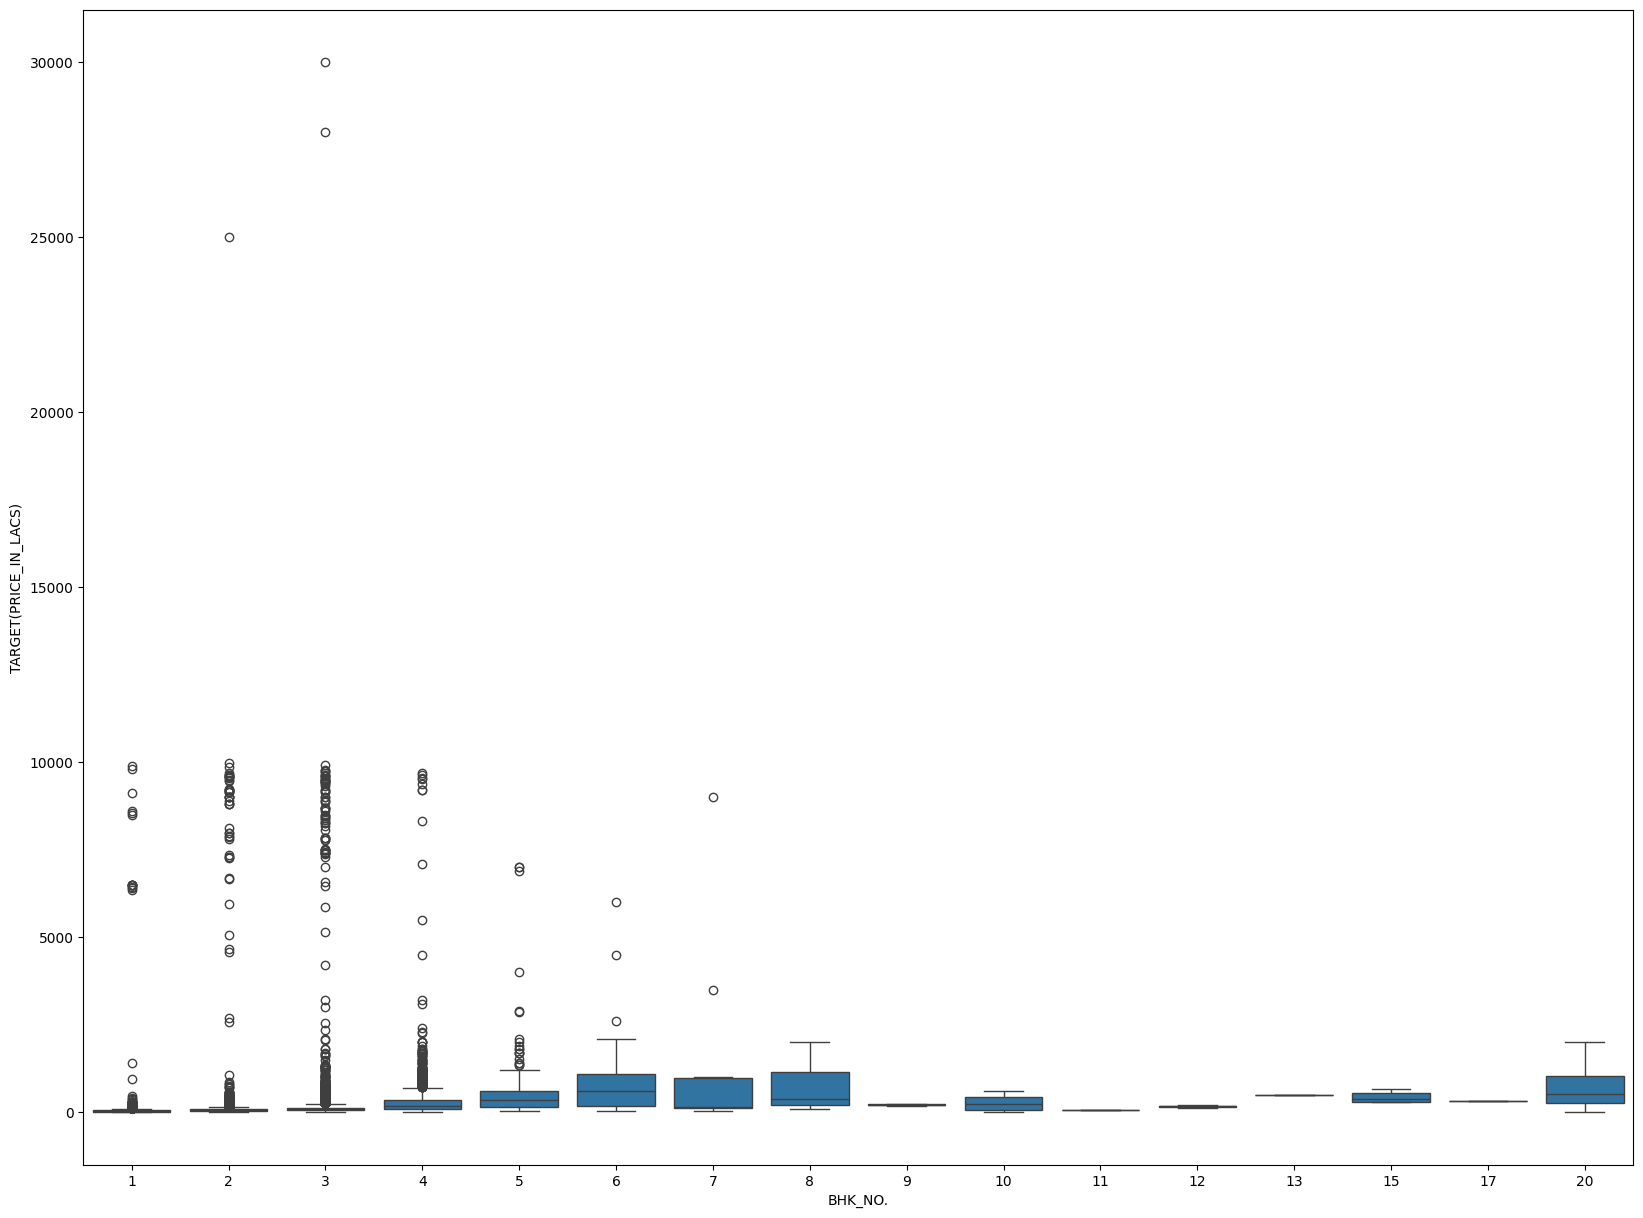

In [41]:
box_plot(data1,'TARGET(PRICE_IN_LACS)')

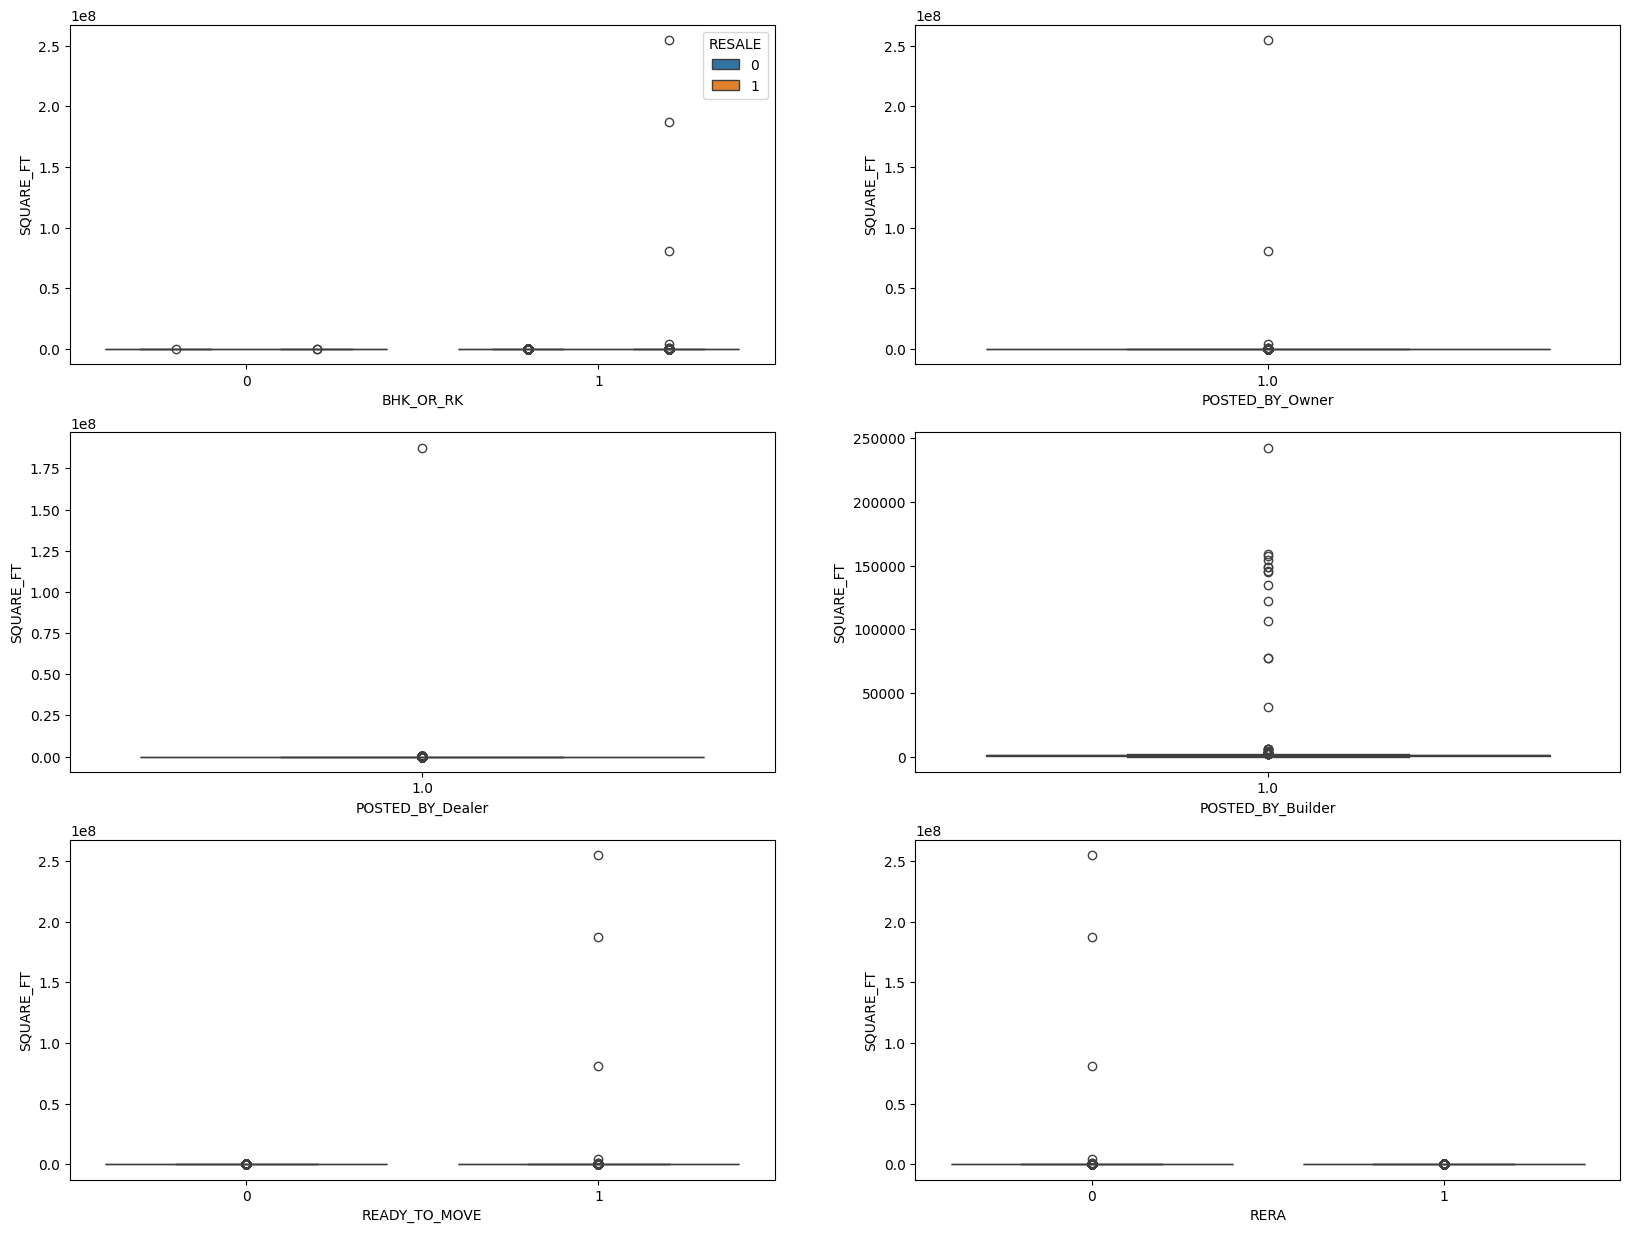

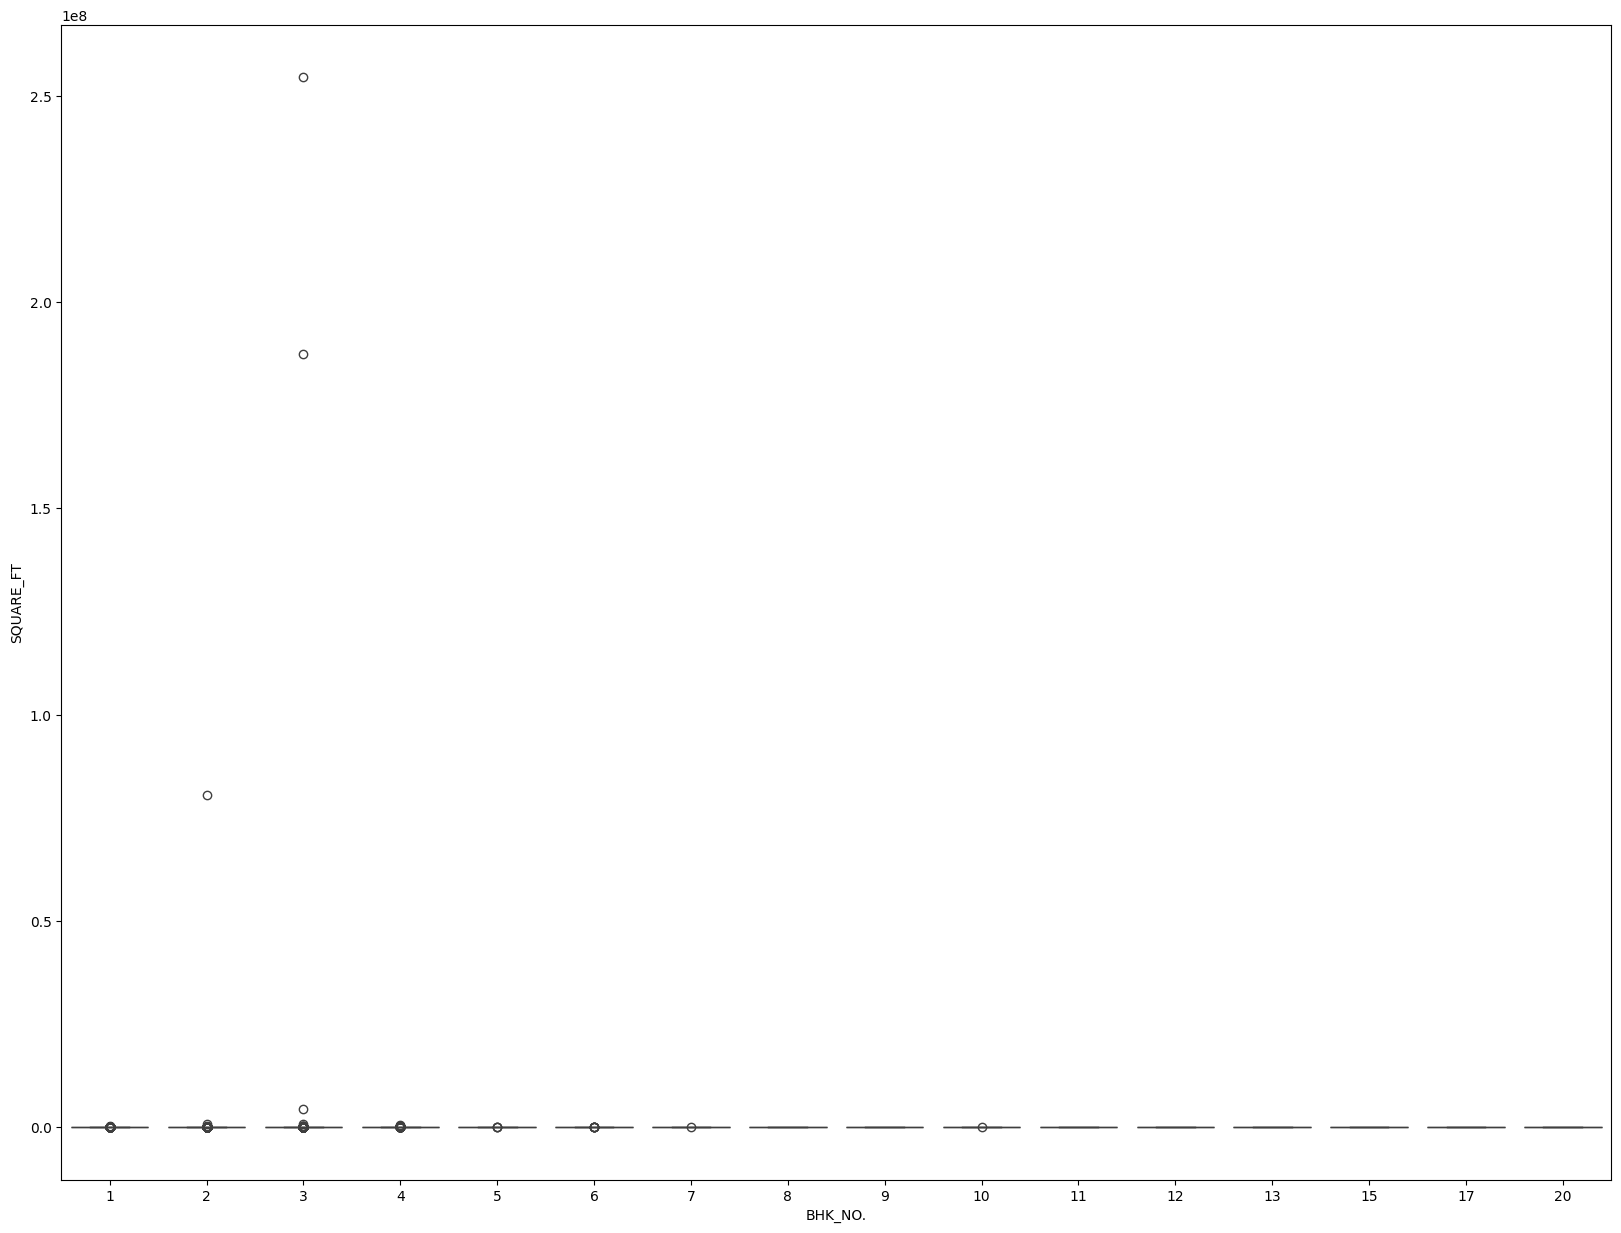

In [42]:
box_plot(data1,'SQUARE_FT')

## data cleaning 

In [43]:
# dropping the duplicated values from datasets
data2 = data1.drop_duplicates() 

# hist-plot tells that data related to BHK > 7 is very less so remove this rows 
data3 = data2[data2['BHK_NO.'] < 7]  

data4 = data3[(data3['TARGET(PRICE_IN_LACS)'] * (10**5) / data3['SQUARE_FT']) > 1000]   

data5 = data4[data4['SQUARE_FT'] > 200] 

# shape of datasets before and after data cleaning 
print(f"before : {data.shape}, after : {data5.shape}")

before : (29451, 12), after : (28143, 13)


## visuallizing the data again after data cleaning

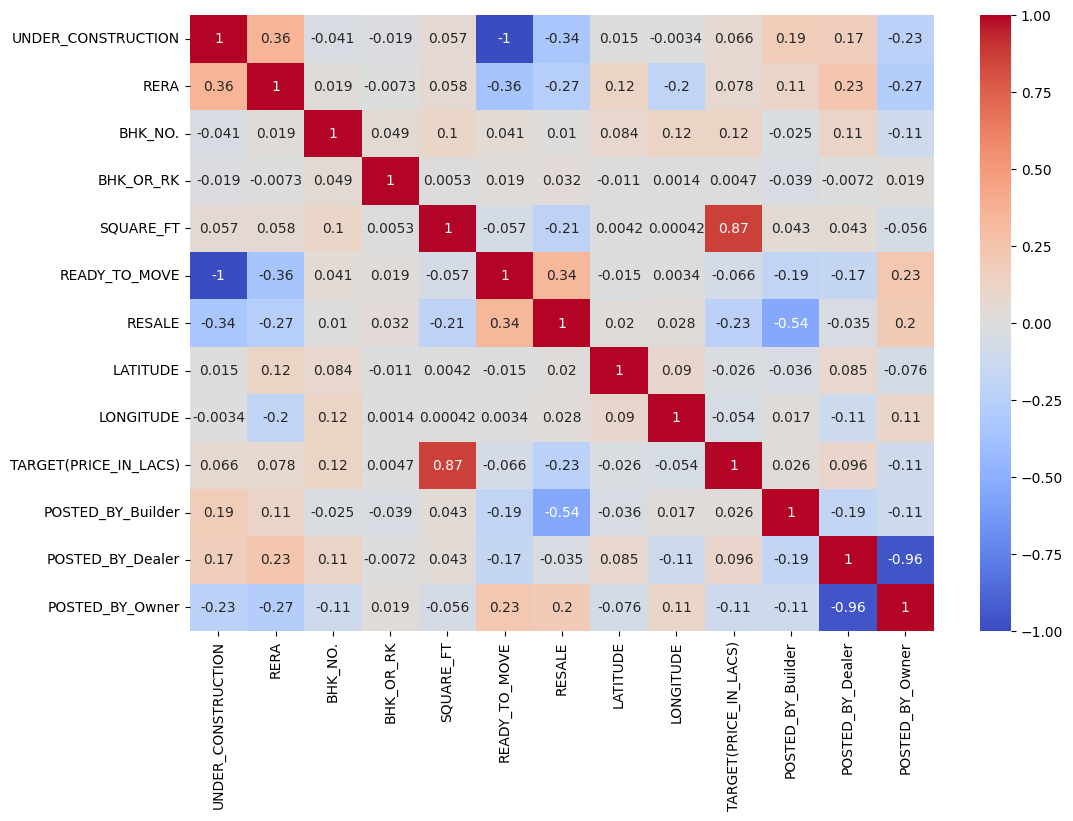

In [44]:
#corelation matrix after cleaning data 
correlation_matrix(data5)

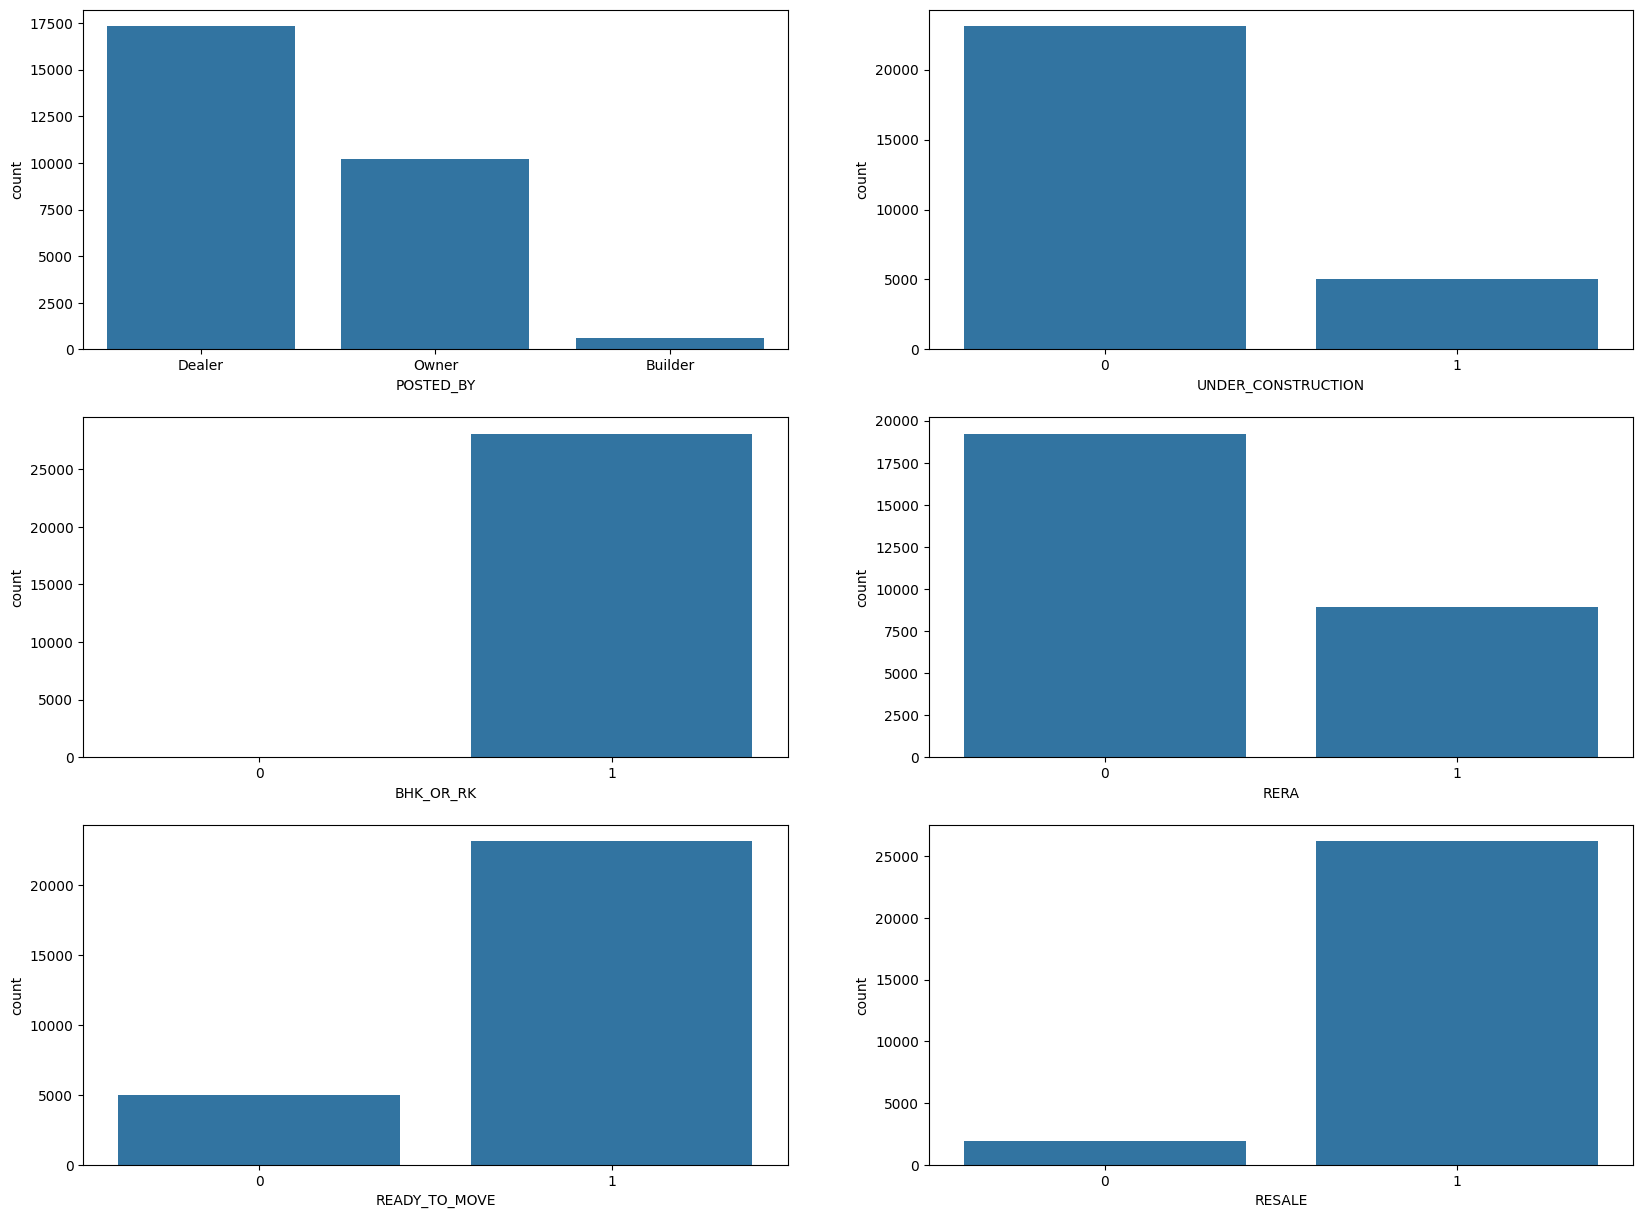

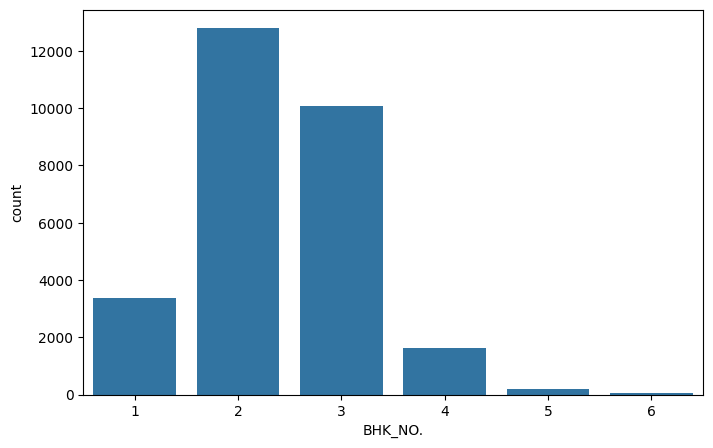

In [45]:
count_plot(data5)

In [46]:
data5['BHK_OR_RK'].value_counts()

BHK_OR_RK
1    28120
0       23
Name: count, dtype: int64

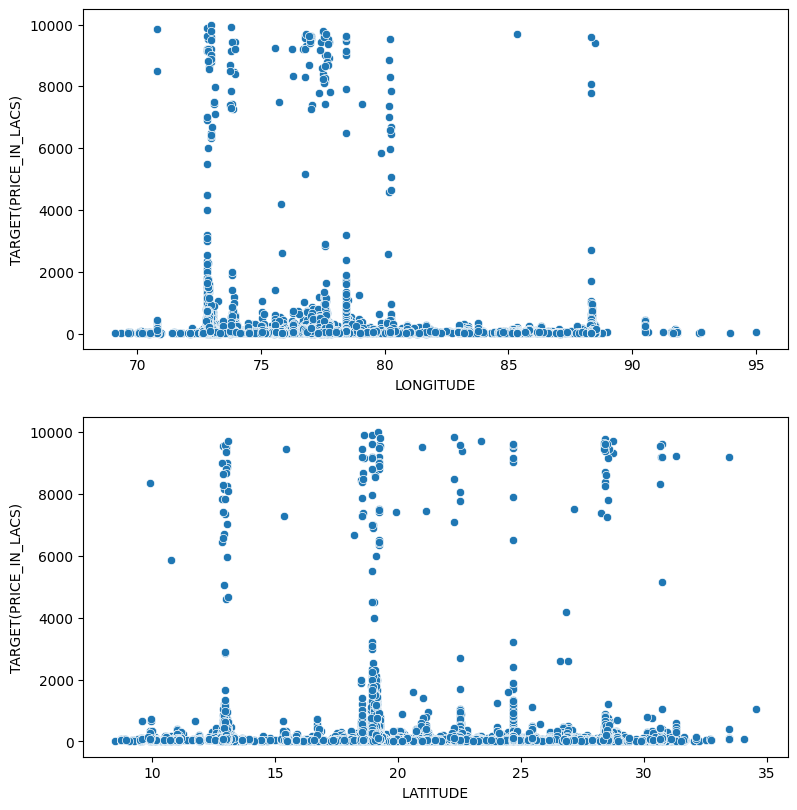

In [47]:
scatter_plot(data5)

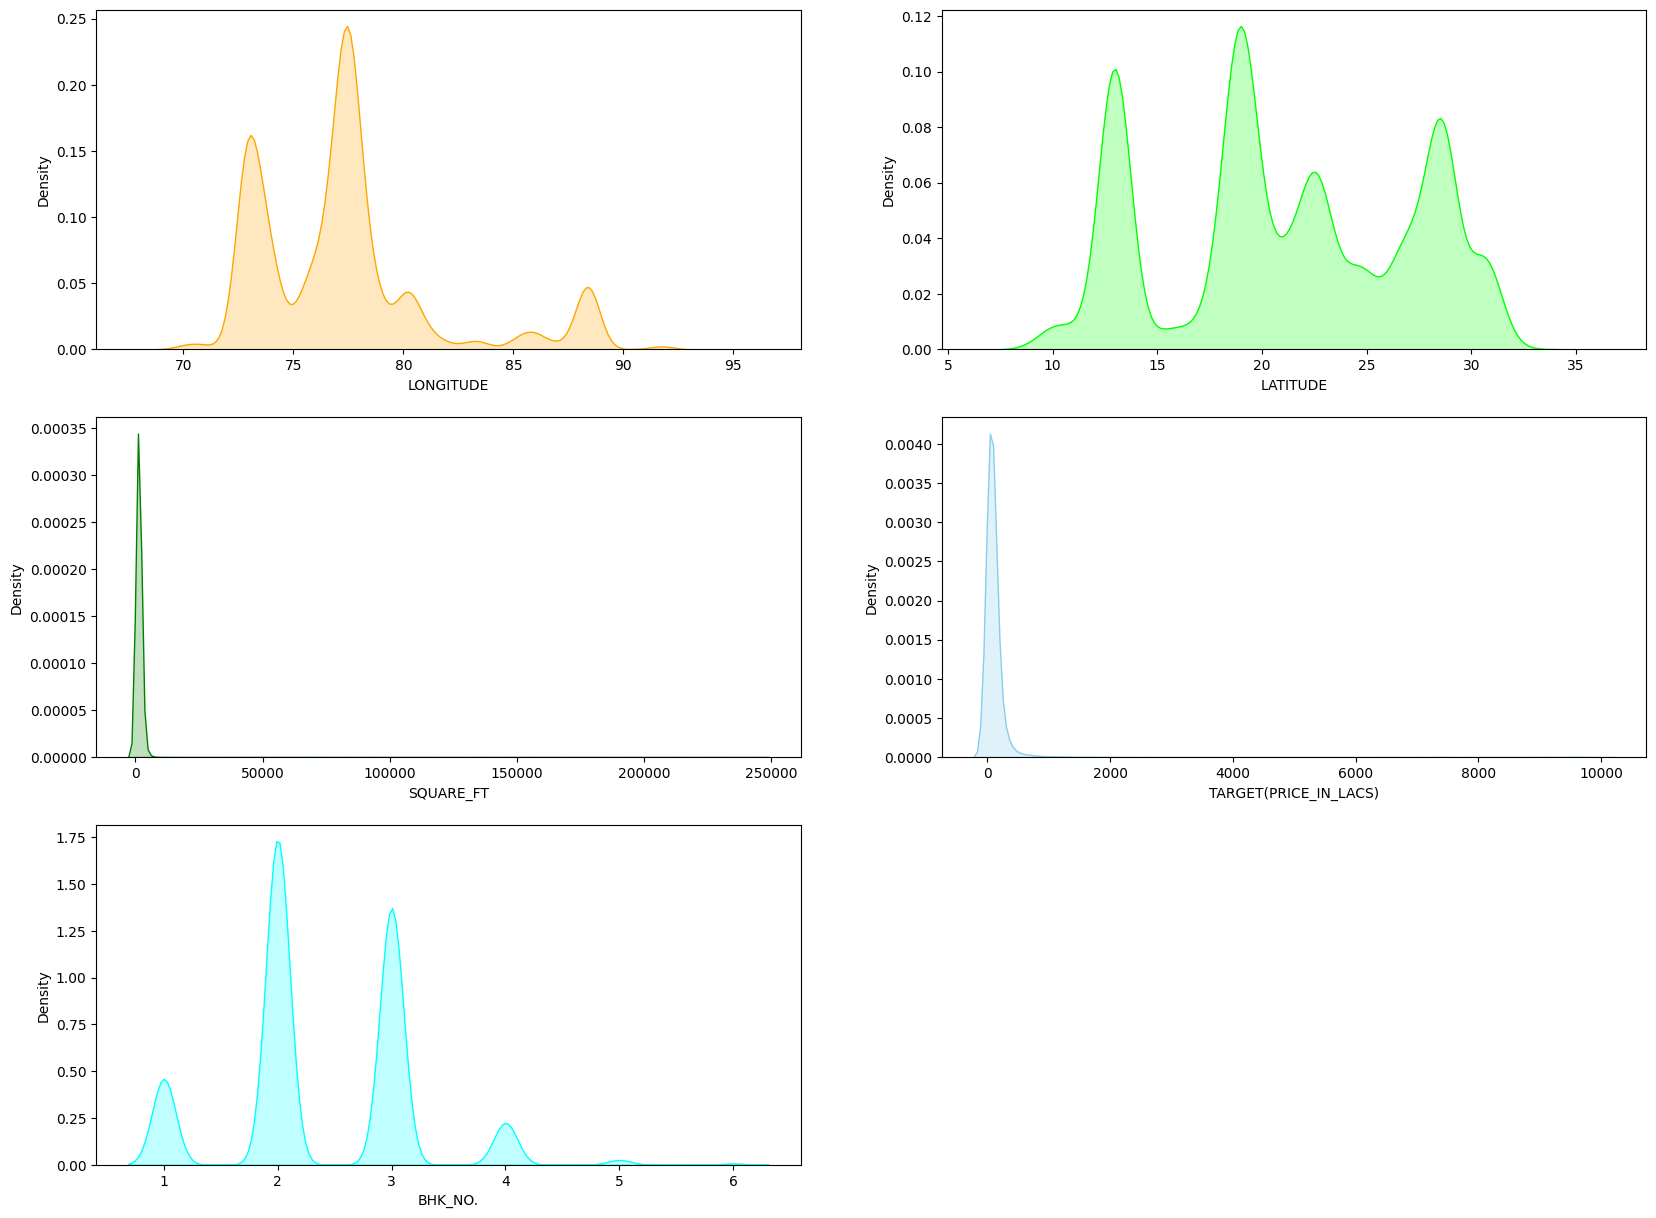

In [48]:
kde_plot(data5)

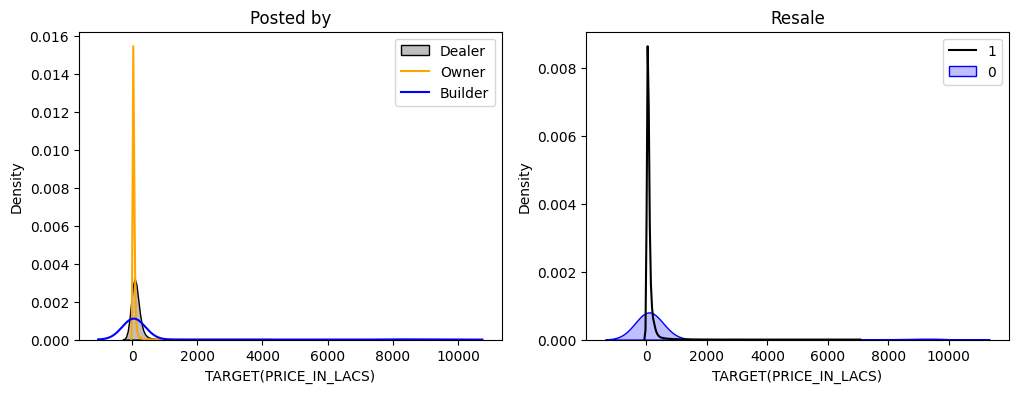

In [49]:
kde_plot_category(data5)

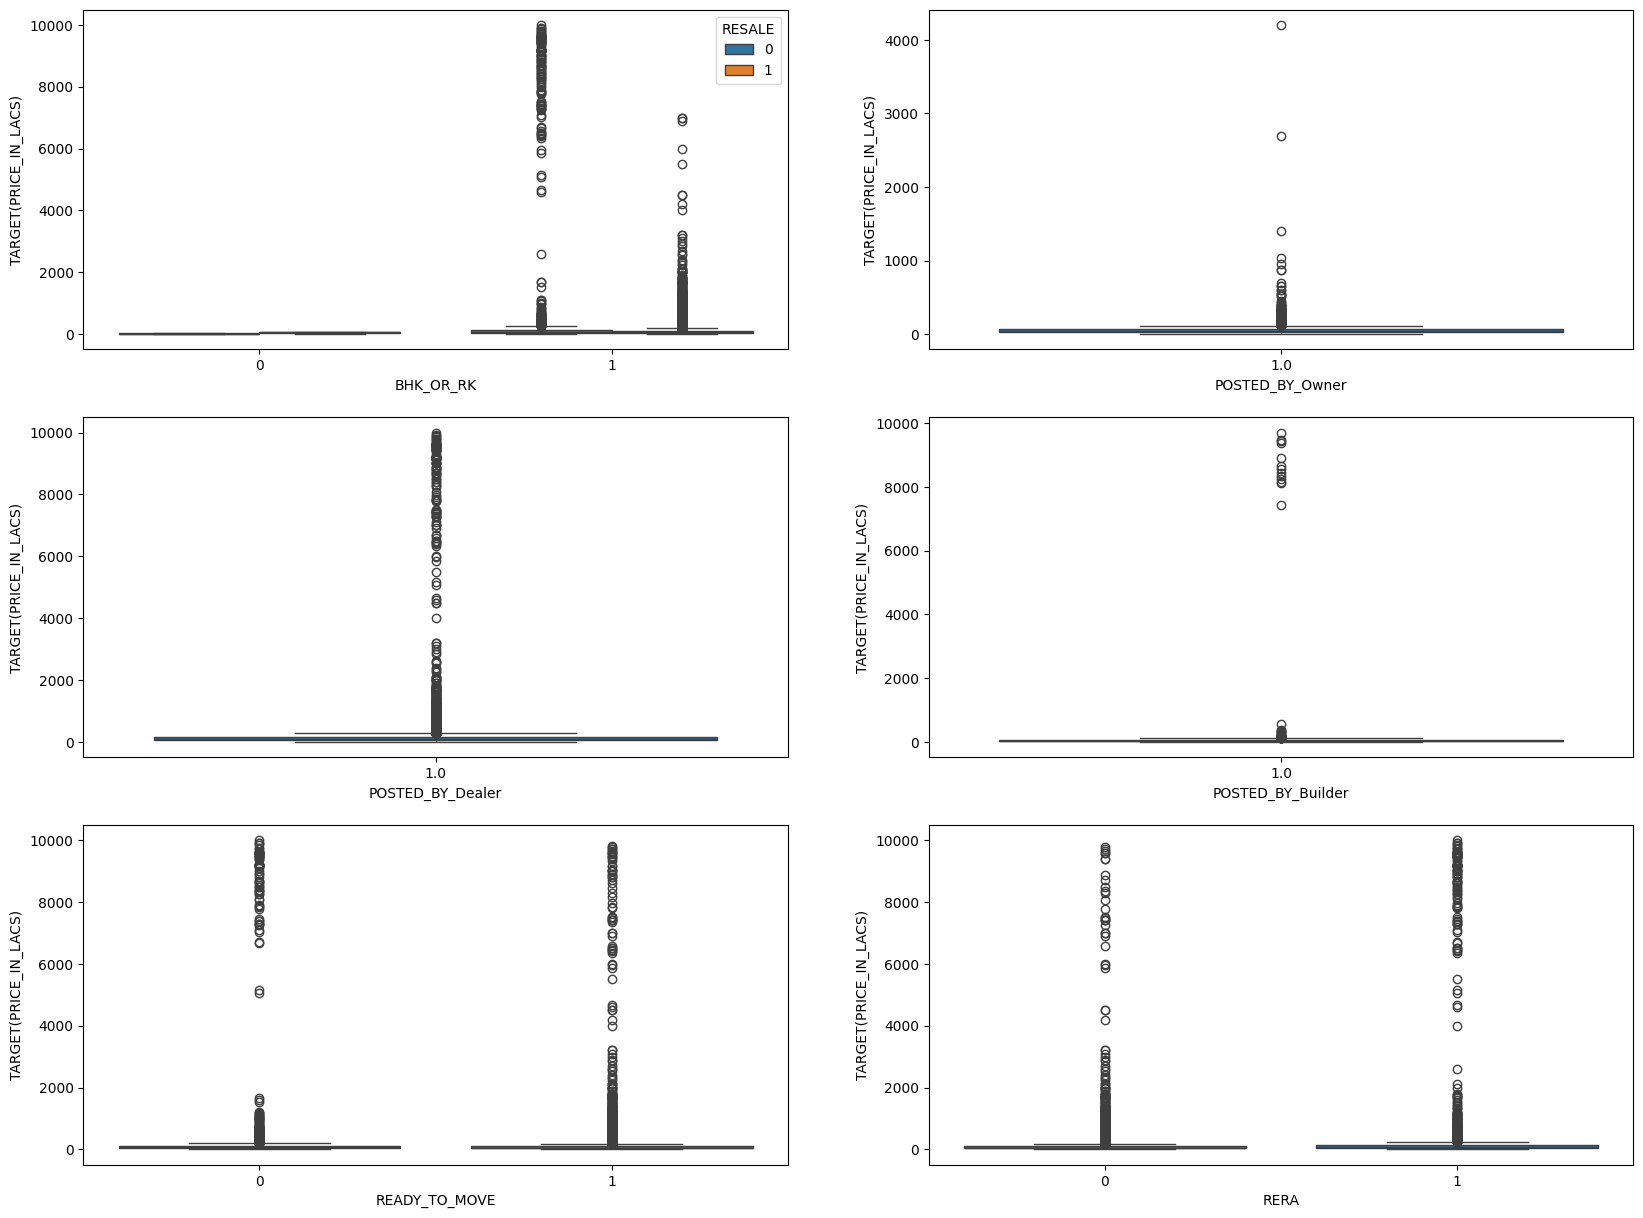

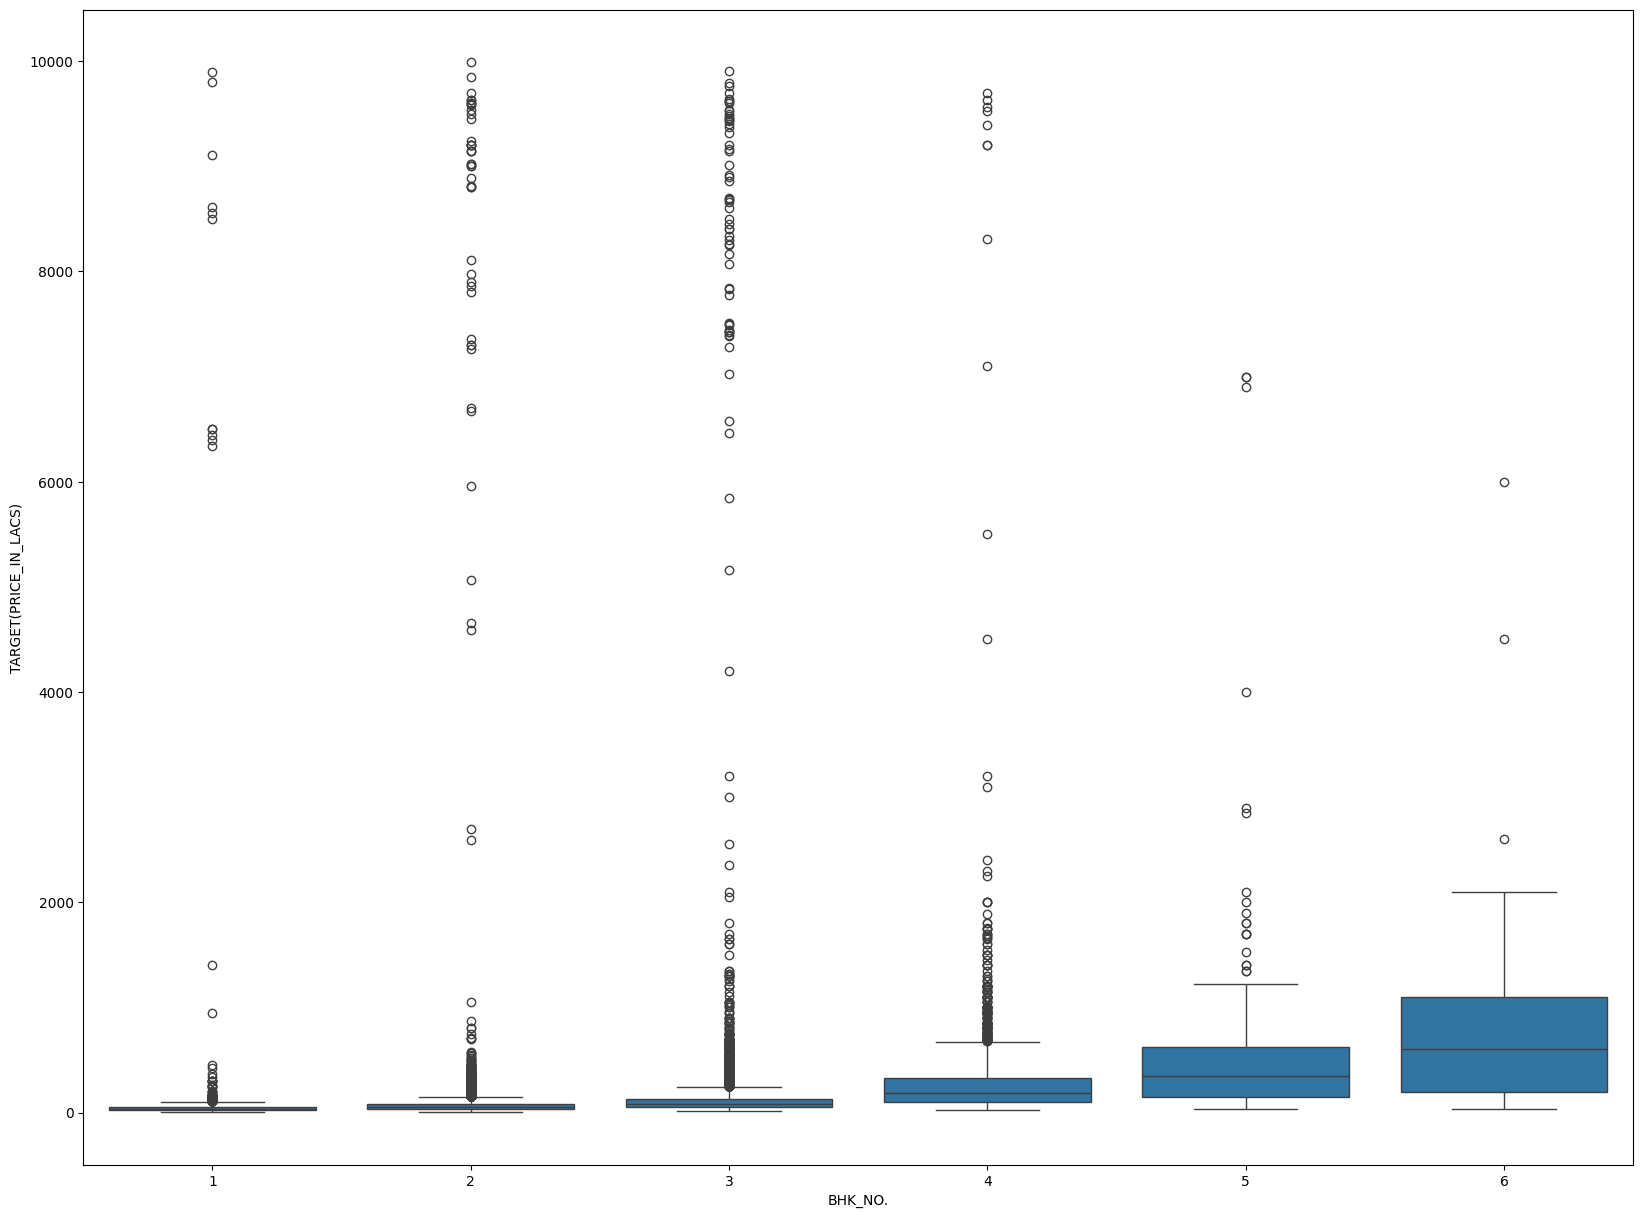

In [50]:
box_plot(data5,'TARGET(PRICE_IN_LACS)')

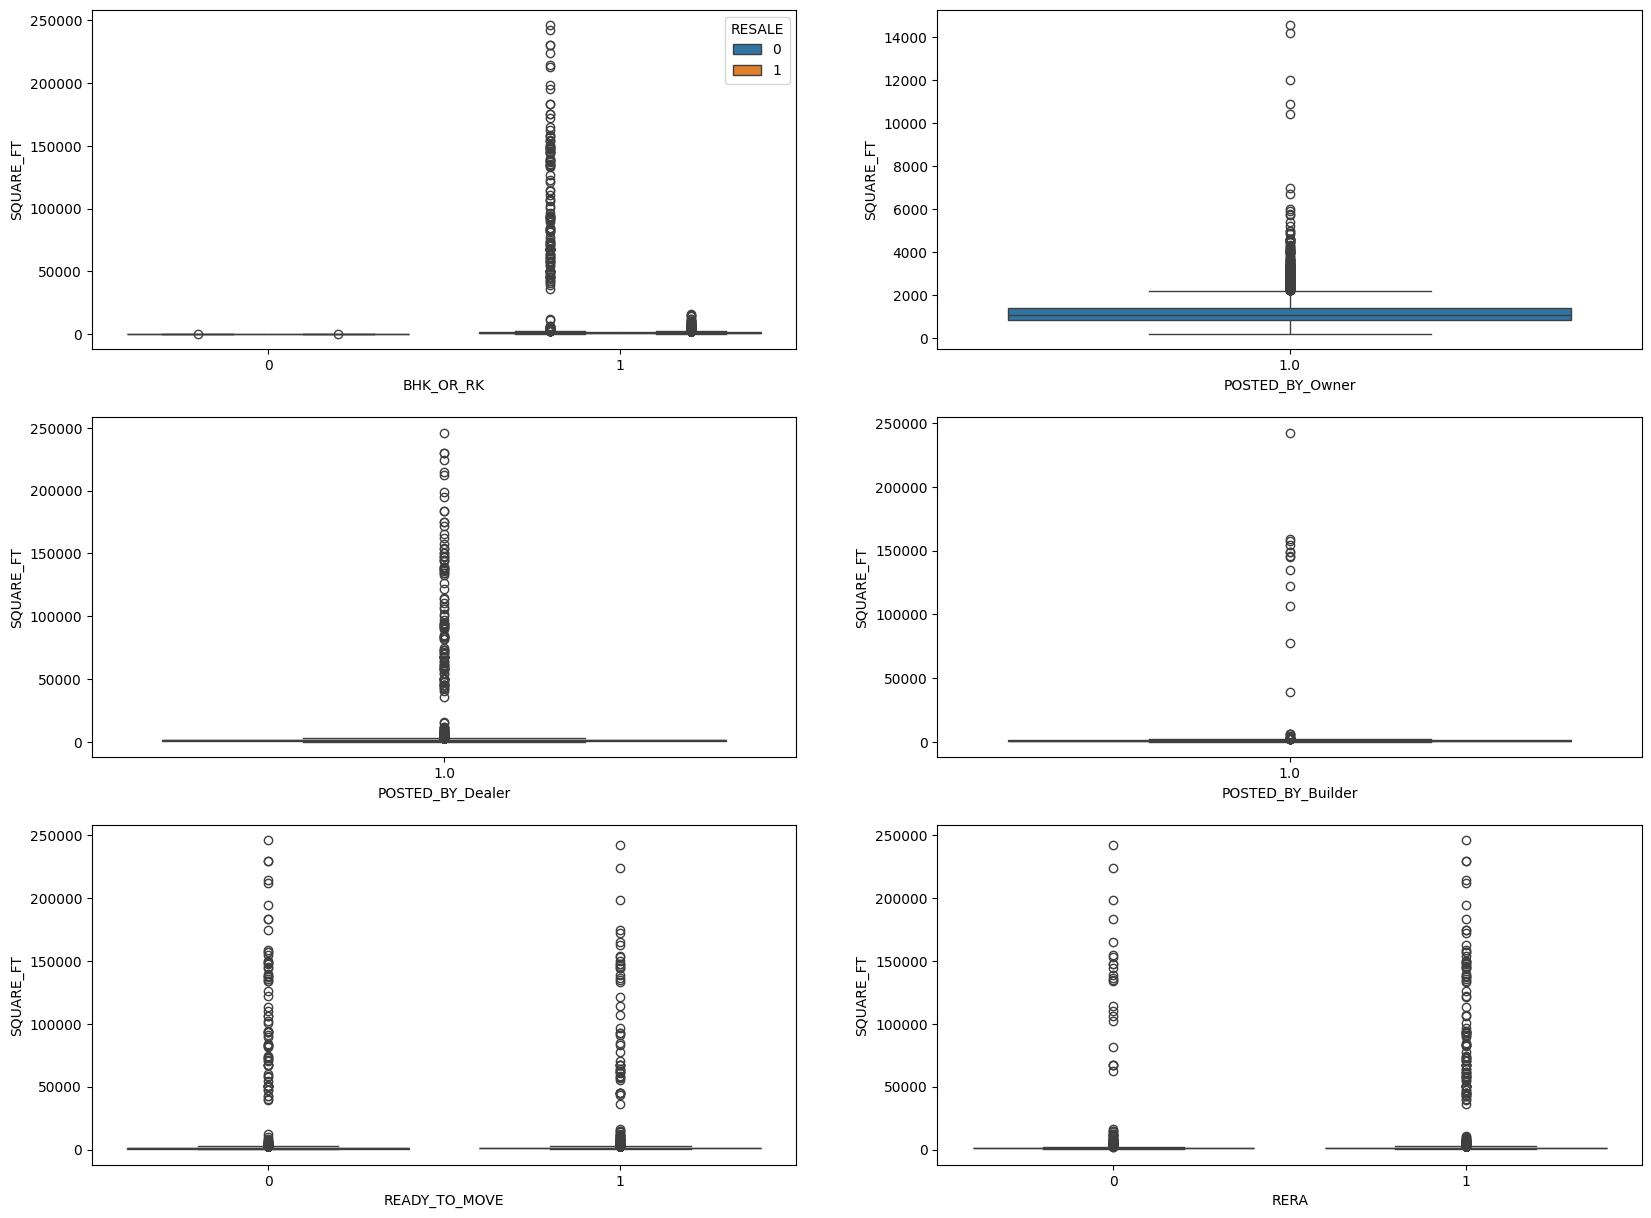

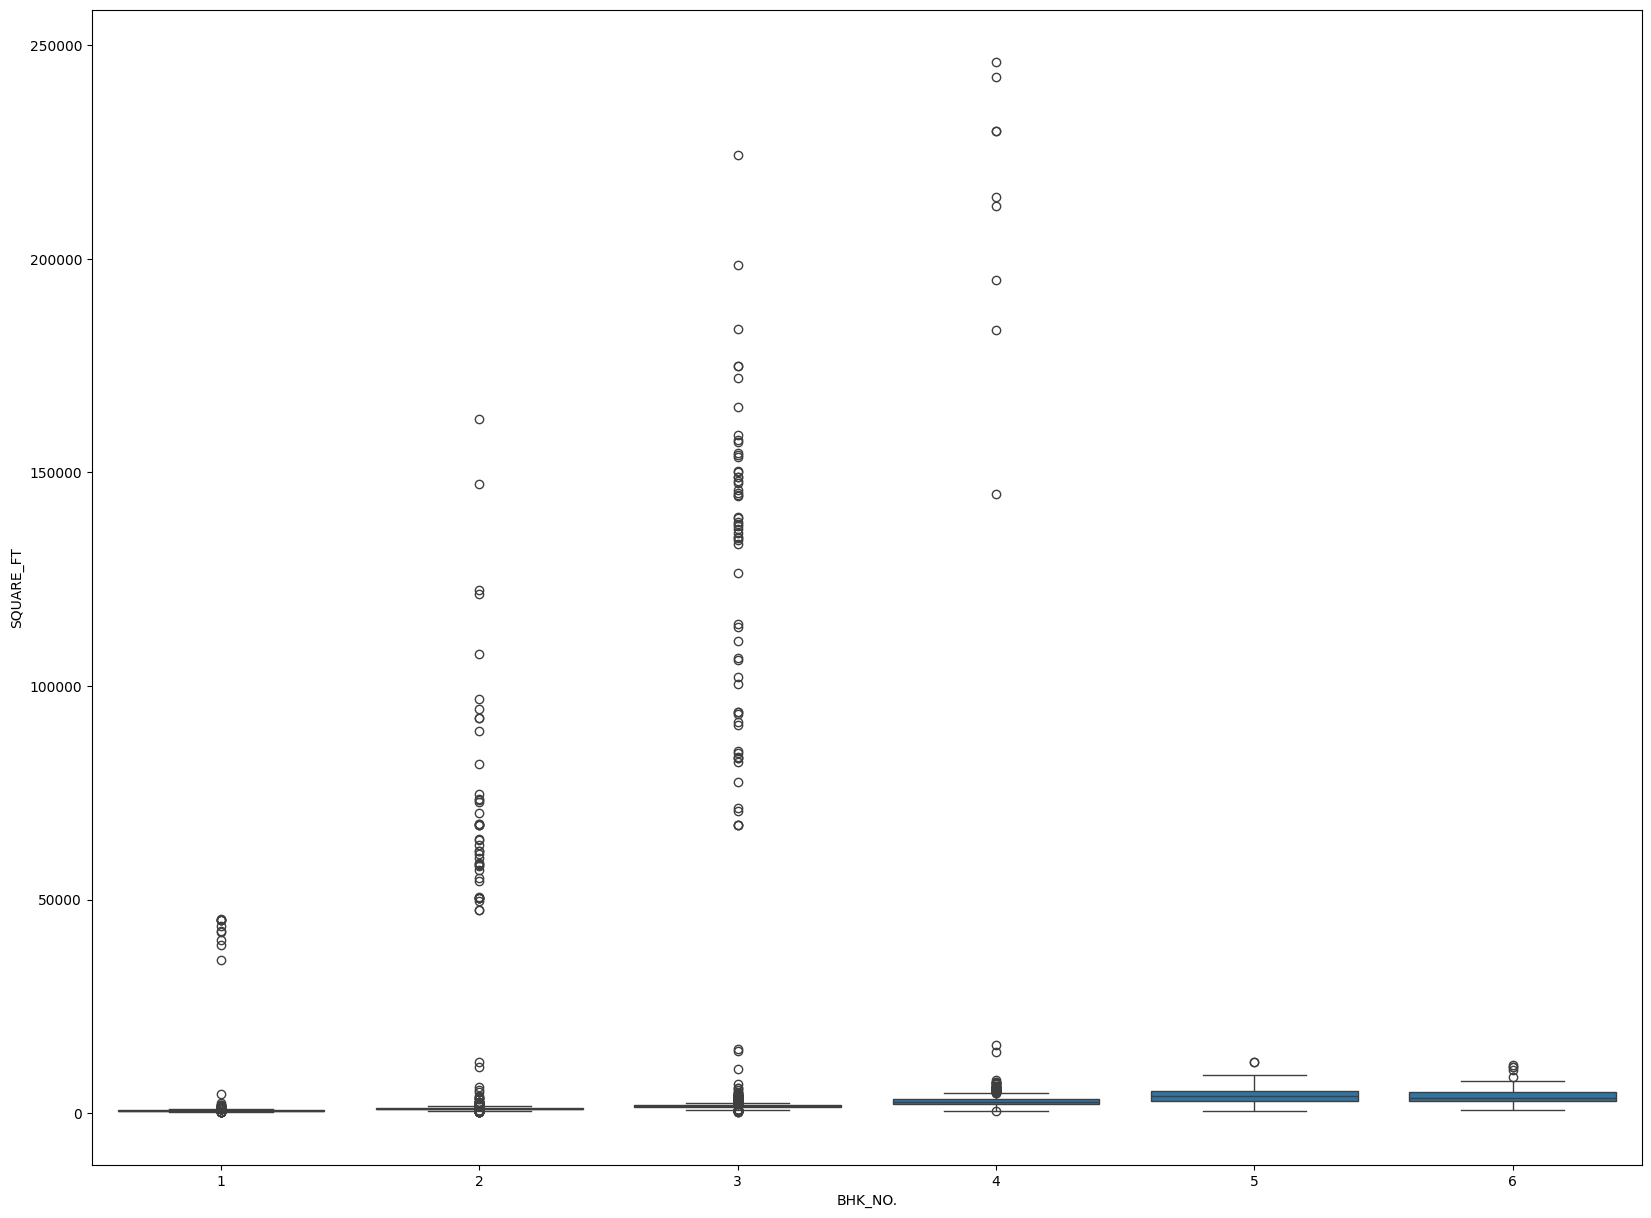

In [51]:
box_plot(data5,'SQUARE_FT')

In [52]:
data5.drop(['READY_TO_MOVE','POSTED_BY_Owner'], axis = 1, inplace = True)

C:\Users\Krushna\AppData\Local\Temp\ipykernel_15180\4011298260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5.drop(['READY_TO_MOVE','POSTED_BY_Owner'], axis = 1, inplace = True)


## feature scaling and splitting the dataset into training and testing set

In [53]:
# split the dataset into features (X) and labels (y)
X = data5.drop('TARGET(PRICE_IN_LACS)', axis = 1)
y = data5['TARGET(PRICE_IN_LACS)']

# scaled the feature data into 0 to 1 (standardization) 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# save the minmaxscaler
directory = Path.cwd() / 'minmaxscaler'
directory.mkdir(parents = True, exist_ok = True)
file_name = directory / 'MinMaxScaler.pkl'
pickle.dump(scaler, open(file_name, 'wb'))

# split the datasets into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 10)


## hyper-parameter tuning

In [54]:
result = find_best_model_using_gridsearchcv(X_train, y_train)
result

,model,best_estimator,best_score,best_params
0,linear_regression,LinearRegression(),0.745754,{'fit_intercept': True}
1,decision_tree,DecisionTreeRegressor(criterion='poisson'),0.931835,"{'criterion': 'poisson', 'splitter': 'best'}"
2,random_forest,"(DecisionTreeRegressor(criterion='poisson', ma...",0.957528,"{'criterion': 'poisson', 'n_estimators': 15}"
3,gradient_boost,([DecisionTreeRegressor(criterion='friedman_ms...,0.923951,"{'criterion': 'friedman_mse', 'learning_rate':..."
4,ada_boost,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.918806,"{'learning_rate': 1, 'loss': 'square', 'n_esti..."
5,xg_boost,"XGBRegressor(base_score=None, booster=None, ca...",0.951678,{'n_estimators': 20}


In [55]:
# store the result (DataFrame) obtained after hyper parameter tuning 
file_name = Path.cwd() / 'hyperparameter_tuned_model' / 'result_obtained_after_tuning.pkl'
pickle.dump(result,open(file_name, 'wb'))

In [56]:
# model_name : result['model']
# open_tuned_model_result('decision_tree')

## calculating r2_score and cross_val_score of each model (best parameter)

In [57]:
result1 = stack_model(result, X_train, y_train, cv = 5)
rows = result1.shape[0]
for row in range(rows):
    cross_val_scores = evaluate_models_cross_val_score(result1['best_estimator'][row], X_train, y_train)
    model_name = result1['model'][row]
    print(f'{model_name}\ncross_validation_score: {cross_val_scores}')
    accuracy(result1['best_estimator'][row], X_test, y_test)
    print()

linear_regression
cross_validation_score: [0.75733411 0.8795679  0.80123561 0.76347592 0.83050375]
mean_absolute_error : 82.20142054787466
mean_squared_error : 105551.2217762601
r2_score : 0.7346105547780443

decision_tree
cross_validation_score: [0.93556722 0.91479549 0.94261169 0.89650904 0.94063587]
mean_absolute_error : 40.278406466512706
mean_squared_error : 29716.789200771796
r2_score : 0.9252825114948654

random_forest
cross_validation_score: [0.95691019 0.95043644 0.9513232  0.94127085 0.96461344]
mean_absolute_error : 32.64099407900812
mean_squared_error : 21026.9939566798
r2_score : 0.947131429016734

gradient_boost
cross_validation_score: [0.9296344  0.94435657 0.92734772 0.93421575 0.94938862]
mean_absolute_error : 56.80037646751194
mean_squared_error : 33127.5147994486
r2_score : 0.9167068592266625

ada_boost
cross_validation_score: [0.93571222 0.92178746 0.92648693 0.89129662 0.93505769]
mean_absolute_error : 97.01668965091547
mean_squared_error : 38329.62724268379
r2_sco

In [58]:
# stacked model
result1.iloc[-1]['best_estimator']

StackingRegressor(cv=5,
                  estimators=[('decision_tree',
                               DecisionTreeRegressor(criterion='poisson')),
                              ('random_forest',
                               RandomForestRegressor(criterion='poisson',
                                                     n_estimators=15)),
                              ('gradient_boost',
                               GradientBoostingRegressor(learning_rate=0.15,
                                                         n_estimators=15)),
                              ('ada_boost',
                               AdaBoostRegressor(learning_rate=1, loss='square',
                                                 n_estimators=10)),
                              ('xg_boost',
                               XGBRe...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression(), n_jobs=-1)

## save the model

In [59]:
result1 = stack_model(result, X_train, y_train, cv = 5)
rows = result1.shape[0]
for row in range(rows):
    save_model(result1['best_estimator'][row], result1['model'][row])

In [60]:
# model_name : result1['model']
model = open_save_model(result1['model'][6])

## Predict the house price

In [61]:
array = predict_price('yes', 'yes', 4, 'bhk', 1000, 'yes', 75, 26, 'owner')

C:\Users\Krushna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
